# Imports

In [1]:
import pandas as pd
import json
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_1samp, ttest_ind
import seaborn as sns
import statsmodels.api as sm
import matplotlib.patches as mpatches


# Load data

In [2]:
df = pd.read_csv('data/Experiment_Result.csv')
df.head()
df.columns

Index(['Unnamed: 0', 'block', 'browser', 'color', 'cookies', 'correct',
       'cpt_response', 'current_time', 'inter_stimulus_interval_index',
       'inter_stimulus_interval_time', 'is_fullscreen', 'key_press', 'mobile',
       'os', 'response', 'responses', 'rt', 'shape', 'stimulus',
       'stimulus_block', 'stimulus_side', 'sub_block', 'subject', 'tags1',
       'tags2', 'time_elapsed', 'time_post_trial', 'trial_began',
       'trial_index', 'trial_type', 'type', 'stimulus_missed'],
      dtype='object')

In [3]:
print('Not fullscreen:', df[df.is_fullscreen == False].shape)

Not fullscreen: (0, 32)


# Validate data

In [4]:
df.drop(df[~df['inter_stimulus_interval_index'].isnull()].index)
df.drop(df.loc[(df['trial_type'] == 'survey-text') &
        (~df['color'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-text') &
        (~df['cpt_response'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-multi-choice')
        & (~df['color'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-multi-choice') &
        (~df['cpt_response'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-likert') &
        (~df['color'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-likert') &
        (~df['cpt_response'].isnull())].index, inplace=True)
df['current_time'] = pd.to_numeric(df['current_time'])


## CPT data

In [5]:
last_time = -1
last_index = -1
lst = []
for index, row in df.iterrows():
    if row.trial_type != 'conjunctive-cpt':
        last_index = -1
        continue
    if row.current_time < last_time:
        lst.append(last_index)
    else:
        last_index = index
    last_time = row.current_time
print(len(lst))


4235


In [6]:
print(df.shape)
df.drop(lst, inplace=True)
print(df.shape)

(43494, 32)
(39259, 32)


In [7]:
def is_cpt_stimulus(cpt_df):
    return cpt_df['shape'] == 'square' and cpt_df['color'] == '#FF0000'

In [8]:
def get_cpt_false_answers(single_df):
    cpt_df = single_df[single_df.trial_type == 'conjunctive-cpt']
    cpt_df = cpt_df[(cpt_df.correct == False) & (cpt_df.cpt_response == 1)]
    return cpt_df.shape[0]

In [9]:
def get_cpt_df(single_df):
    cpt_df = single_df[single_df.trial_type == 'conjunctive-cpt']
    trial_types = cpt_df.trial_index.unique()
    cpt_df = cpt_df[cpt_df.trial_index == trial_types[1]]
    cpt_df['is_cpt_stimulus'] = cpt_df.apply(is_cpt_stimulus, axis=1)
    cpt_df = cpt_df[(cpt_df.is_cpt_stimulus == True) | (cpt_df.cpt_response == 1)]
    return cpt_df

In [10]:
def get_cpt_false_answers(single_df):
    cpt_df = single_df[single_df.trial_type == 'conjunctive-cpt']
    cpt_df = cpt_df[(cpt_df.correct == False) & (cpt_df.cpt_response == 1)]
    return cpt_df.shape[0]


In [11]:
def get_clean_cpt_df(single_df):
    cpt_df = get_cpt_df(single_df)
    rapid_cpt_response_indexes = []
    last_is_response = False
    count = 0
    for index, row in cpt_df.iterrows():
        if row.cpt_response == 1:
            if last_is_response:
                count += 1
                rapid_cpt_response_indexes.append(index)
            else:
                last_is_response = True
        else:
            last_is_response = False
    cpt_df.drop(rapid_cpt_response_indexes, inplace=True)
    return cpt_df

In [12]:
def get_cpt_result_df(single_df, log_value = True, min_value = 0.2):
    cpt_df = get_clean_cpt_df(single_df)
    cpt_df['cpt_response_time']  = cpt_df['current_time'].diff()
    cpt_df['cpt_response_time']  = cpt_df[cpt_df.cpt_response_time > min_value].cpt_response_time
    if log_value: 
        cpt_df['cpt_response_time'] = np.log(cpt_df['cpt_response_time'])
    return cpt_df

In [13]:
def get_cpt_resuslt(single_df, log_value = True):
    cpt_df = get_cpt_result_df(single_df, log_value)
    return cpt_df['cpt_response_time']


In [14]:
def get_standards_cpt_result(single_df, log_value = True):
    cpt_result = get_cpt_result_df(single_df, log_value)
    cpt_result_mean = cpt_result.cpt_response_time.mean()
    cpt_result_std = cpt_result.cpt_response_time.std()
    cpt_standard_df = cpt_result[(cpt_result.cpt_response_time > cpt_result_mean - 3 * cpt_result_std) & (cpt_result.cpt_response_time < cpt_result_mean + 3 * cpt_result_std)]    
    return cpt_standard_df.cpt_response_time

## RMS

In [15]:
def get_raw_rms_df(single_df, with_training=False):
    if with_training:
        return single_df[single_df.trial_type == 'bRMS']
    else:
        return single_df[(single_df.trial_type == 'bRMS') & (single_df.stimulus_block != "training")]


In [16]:
def get_brms_missed_count(brms_df):
    brms_missed = brms_df[((brms_df.key_press != 'P') & (brms_df.stimulus_side == 0)) | (
            (brms_df.key_press != 'Q') & (brms_df.stimulus_side == 1))]
    return brms_missed.shape[0]

In [17]:
def get_brms_df(single_df, log_value = True):
    rms_df = get_raw_rms_df(single_df)
    rms_df = rms_df[~(((rms_df.key_press != 'P') & (rms_df.stimulus_side == 0)) | (
        (rms_df.key_press != 'Q') & (rms_df.stimulus_side == 1)))]
    brms_df = rms_df[(rms_df.rt < 12000) & (rms_df.rt > 80)]
    if log_value:
        brms_df['rt'] = np.log(brms_df.rt)
    return brms_df


In [18]:
def get_rms_standards(brms_df):
    mean_rt = brms_df.rt.mean()
    std_rt = brms_df.rt.std()
    brms_standard_df = brms_df[(brms_df.rt > mean_rt - (3 * std_rt)) & (brms_df.rt < mean_rt + (3 * std_rt))]    
    return brms_standard_df
    

In [19]:
def get_rms_values(single_df, is_standard = False, is_log = True):
    if is_standard:
        brms_df = get_rms_standards(get_brms_df(single_df, is_log))
    else:
        brms_df = get_brms_df(single_df, is_log)
    rt_blocks_mean = brms_df.groupby('stimulus_block').rt
    blocks_rt = rt_blocks_mean.apply(list)
    return [brms_df.rt.mean(), brms_df.rt.std(), 
            statistics.mean(blocks_rt[0]), statistics.mean(blocks_rt[1]), statistics.mean(blocks_rt[2]), statistics.mean(blocks_rt[3]),
            brms_df.stimulus_block, brms_df.shape[0]]


In [20]:
def shaming_rms():
    for bad_boy in bad_boys_rms:
        brms_df = bad_boy[(bad_boy.trial_type == 'bRMS') &
                          (bad_boy.stimulus_block != "training")]

        print(brms_df.groupby(by=['key_press']).trial_type.count())
        plt.xlabel('rt')
        plt.ylabel('count')
        plt.hist(brms_df.rt, bins=100)
        plt.show()
    peoples = {'Shit': 0, 'Stupid': 0, 'Decent': 0}
    for one in peoples_lst:
        if one >= 0.45:
            peoples['Shit'] += 1
        elif one >= 0.15:
            peoples['Stupid'] += 1
        else:
            peoples['Decent'] += 1
    print(peoples)


In [21]:
def get_rms_histogram_real_vs_standards():
    for single_df in df_lst:
        brms_df = get_brms_df(single_df)
        brms_standard_df = get_rms_standards(brms_df)
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

        axes[0].set_xlabel('rt')
        axes[0].set_ylabel('count')
        axes[0].hist(brms_df.rt, bins=100)

        axes[1].set_xlabel('rt standard')
        axes[1].set_ylabel('count')
        axes[1].hist(brms_standard_df.rt, bins=100)
        plt.show()


In [22]:
df.groupby(['trial_type']).size()

trial_type
bRMS                    3150
conjunctive-cpt        34724
instructions             350
survey-likert            450
survey-multi-choice      360
survey-text              225
dtype: int64

In [23]:
cpt_training_options = [6, 13, 78, 85]
cpt_options = [8, 15, 80, 87]
asrs_options = [6, 10, 78, 82]

values = {
    "age": 2,
    "brms_understood": [88],
    "brms_stratagy_exist": [89],
    "brms_stratagy": [90],
    "cpt_understood": [91],
    "cpt_stratagy_exist": [92],
    "cpt_stratagy": [93],
    "your_driving": [94],
    "accedint_driver": [95],
    "accedint_walker": [96],
    "hps1": [98],
    "hps2": [99],
    "hps3": [100],
    "hps4": [101],
}

In [24]:
def word_to_bool(x):
    if type(x) == str:
        if str.lower(x) in ['כן', 'ימין','נכון', 'אישה']:
            return 1
        else:
            return 0
    else:
        return x

In [25]:
def get_hps_count(single_df):
    count = 0
    for i in range(98, 102):
        answer_df = single_df[(single_df.trial_index == i)
                              & (~single_df.responses.isnull())].responses
        obj = json.loads(answer_df.iloc[0])
        count += word_to_bool(obj.get('Q0')) + \
            word_to_bool(obj.get('Q1')) + word_to_bool(obj.get('Q2'))
    return count


## Else

In [26]:
df.drop(df.loc[df['trial_type'] == 'instructions'].index, inplace=True)

In [27]:
def get_values(single_df):
    lst = []
    for key, value in values.items():
        currnet = single_df[(single_df.trial_index == value[0]) & (~single_df.responses.isnull())].responses
        print(currnet.empty, value[0])
        obj = json.loads(currnet.iloc[0])
        if len(obj.keys()) > 1:
            for i in range(len(obj.keys())):
                lst.append(obj.get('Q' + str(i)))
        else:   
            lst.append(obj.get('Q0'))
    return lst

In [28]:
def get_age(single_df):
    age_df = single_df[single_df.trial_index == 2].responses
    return json.loads(age_df.iloc[0]).get("Q0")

In [29]:
def tanslate_heb(value):
    if value == 'אישה':
        return 'Female'
    elif value == 'גבר':
        return "Male"
    elif value == 'ימין':
        return 'Right'
    elif value == 'שמאל':
        return 'Left'
    elif value == 'נכון':
        return 'True'
    elif value == 'לא נכון':
        return 'False'
    elif value == 'כן':
        return 'Yes'
    elif value == 'לא':
        return 'No'
    elif value == 'עברית':
        return 'Hebrew'
    elif value == 'ערבית':
        return 'Arabic'
    elif value == 'אנגלית':
        return 'English'
    elif value == 'אחר':
        return 'Else'
    else:
        return value

In [30]:
def fix_heb_columns(df):
    df['feel_adhd'] = pd.to_numeric(df['feel_adhd'])
    df['asrs_count'] = pd.to_numeric(df['asrs_count'])

    # df['accedint_driver'] = pd.to_numeric(df['accedint_driver'])
    # df['accedint_walker'] = pd.to_numeric(df['accedint_walker'])

    # df['age'] = pd.to_numeric(df['age'])
    # df['strong_hand'] = df['strong_hand'].apply(tanslate_heb)
    # df['main_lang'] = df['main_lang'].apply(tanslate_heb)
    # df['gender'] = df['gender'].apply(tanslate_heb)


## ASRS

In [31]:
def get_asrs_start(single_df):
    for option in asrs_options:
        asrs_1 = single_df[(single_df.trial_index == option)
                           & (~single_df.responses.isnull())]
        if not asrs_1.empty:
            return option


In [32]:
def get_asrs_answers(single_df):
    start_asrs = get_asrs_start(single_df)
    asrs_1_df = single_df[(single_df.trial_index == start_asrs) & (
        ~single_df.responses.isnull())].responses

    asrs_1_obj = json.loads(asrs_1_df.iloc[0])
    asrs_1 = asrs_1_obj.get('Q0')
    asrs_2 = asrs_1_obj.get('Q1')
    asrs_3 = asrs_1_obj.get('Q2')

    asrs_2_df = single_df[(single_df.trial_index == start_asrs + 1)
                          & (~single_df.responses.isnull())].responses
    asrs_2_obj = json.loads(asrs_2_df.iloc[0])
    asrs_4 = asrs_2_obj.get('Q0')
    asrs_5 = asrs_2_obj.get('Q1')
    asrs_6 = asrs_2_obj.get('Q2')

    asrs_3_df = single_df[(single_df.trial_index == start_asrs + 2)
                          & (~single_df.responses.isnull())].responses
    obj = json.loads(asrs_3_df.iloc[0])
    asrs_7 = obj.get('Q0')
    asrs_8 = obj.get('Q1')
    asrs_9 = obj.get('Q2')

    asrs_4_df = single_df[(single_df.trial_index == start_asrs + 3)
                          & (~single_df.responses.isnull())].responses
    obj = json.loads(asrs_4_df.iloc[0])
    asrs_10 = obj.get('Q0')
    asrs_11 = obj.get('Q1')
    asrs_12 = obj.get('Q2')

    asrs_5_df = single_df[(single_df.trial_index == start_asrs + 4)
                          & (~single_df.responses.isnull())].responses
    obj = json.loads(asrs_5_df.iloc[0])
    asrs_13 = obj.get('Q0')
    asrs_14 = obj.get('Q1')
    asrs_15 = obj.get('Q2')

    asrs_6_df = single_df[(single_df.trial_index == start_asrs + 5)
                          & (~single_df.responses.isnull())].responses
    obj = json.loads(asrs_6_df.iloc[0])
    asrs_16 = obj.get('Q0')
    asrs_17 = obj.get('Q1')
    asrs_18 = obj.get('Q2')

    sum_part_one = asrs_1 + asrs_2 + asrs_3 + asrs_4 + asrs_5 + asrs_6
    sum_part_two = asrs_7 + asrs_8 + asrs_9 + asrs_10 + asrs_11 + \
        asrs_12 + asrs_13 + asrs_14 + asrs_15 + asrs_16 + asrs_17 + asrs_18

    return [sum_part_one, sum_part_two]


In [33]:
def get_q1_answers(single_df):
    q1_df = single_df[single_df.trial_index == 1].responses
    q1_obj = json.loads(q1_df.iloc[0])
    return [q1_obj.get('Q0'), q1_obj.get('Q1'), q1_obj.get('Q2')]

In [34]:
def get_one_value(single_df, index):
    try:
        value_df = single_df[single_df.trial_index == index].responses
        return json.loads(value_df.iloc[0]).get("Q0")
    except:
        return ''

# Divide to subjects

In [35]:
count = 0
df_lst = []
bad_boys_rms = []
bad_boys_cpt = []
peoples_lst = []
one_df = pd.DataFrame()
for index, row in df.iterrows():
    if row['Unnamed: 0'] == 1 and not one_df.empty:
        brms_missed = get_brms_missed_count(get_raw_rms_df(one_df))
        cpt_false_answers = get_cpt_false_answers(one_df)
        if cpt_false_answers > 34:
            bad_boys_cpt.append(one_df)
        elif brms_missed / 60 >= 0.15:
            bad_boys_rms.append(one_df)
        else:
            df_lst.append(one_df)
        peoples_lst.append(brms_missed / 60)
        one_df = pd.DataFrame()
    one_df = one_df.append(row)



KeyboardInterrupt: 

In [ ]:
print("Cpt bad boys:", len(bad_boys_cpt))
print("RMS bad boys", len(bad_boys_rms))

Cpt bad boys: 2
RMS bad boys 7


# Results

In [ ]:
def get_result_df():
    result_df = pd.DataFrame()
    for df_current in df_lst:
        rms_anwers = get_rms_values(df_current, is_standard=True, is_log=False)
        cpt_response = get_standards_cpt_result(df_current, log_value=False)
        stimulus_missed = df_current[~df_current.stimulus_missed.isnull(
        )].shape[0]
        asrs_answers = get_asrs_answers(df_current)
        cpt_false = get_cpt_false_answers(df_current)
        q1_answers = get_q1_answers(df_current)
        result_df = result_df.append(
            {
                'age': get_one_value(df_current, 2),
                'gender': q1_answers[0],
                'strong_hand': q1_answers[1],
                'main_lang': q1_answers[2],
                'adhd': get_one_value(df_current, 3),
                'feel_adhd': get_one_value(df_current, 4),
                'brms_rt_mean': rms_anwers[0],
                # 'brms_rt_mean_std': rms_anwers[1],
                'brms_rt_mean_regular': rms_anwers[2] + rms_anwers[4],
                'brms_rt_mean_reverted': rms_anwers[3] + rms_anwers[5],
                # 'brms_trial_count': rms_anwers[6],
                # 'asrs_1_count': asrs_answers[0],
                'asrs_count': asrs_answers[1] + asrs_answers[0],
                'asrs_high_adhd': asrs_answers[0] >= 24 or asrs_answers[1] >= 24,
                # 'asrs_med_adhd': 17 <= asrs_answers[0] < 24 or 17 <= asrs_answers[1] < 24,
                'cpt_response_mean': cpt_response.mean(),
                'cpt_response_mean_std': cpt_response.std(),
                #'cpt_misses': stimulus_missed,
                #'cpt_false': cpt_false,
                'cpt_errors': cpt_false + stimulus_missed,
                'hps_count': get_hps_count(df_current),
                # "brms_understood": get_one_value(df_current, 88),
                # "brms_stratagy_exist": get_one_value(df_current, 89),
                # "brms_stratagy": get_one_value(df_current, 90),
                #"cpt_understood": get_one_value(df_current, 91),
                #"cpt_stratagy_exist": get_one_value(df_current, 92),
                # "cpt_stratagy": get_one_value(df_current, 93),
                # "your_driving": get_one_value(df_current, 94),
                # "accedint_driver": get_one_value(df_current, 95),
                # "accedint_walker": get_one_value(df_current, 96),
            }, ignore_index=True)

    return result_df


In [ ]:
result_df = get_result_df()

<AxesSubplot:>

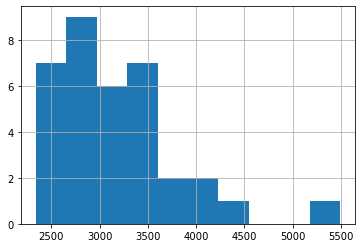

In [ ]:
result_df.brms_rt_mean_reverted.hist()

In [ ]:
result_df.to_csv('result.csv')

In [ ]:
result_df['sub_regular_reverted'] = (result_df['brms_rt_mean_regular'] - result_df['brms_rt_mean_reverted'])

In [ ]:
fix_heb_columns(result_df)
result_df.head(50)

,age,gender,strong_hand,main_lang,adhd,feel_adhd,brms_rt_mean,brms_rt_mean_regular,brms_rt_mean_reverted,asrs_count,asrs_high_adhd,cpt_response_mean,cpt_response_mean_std,cpt_errors,hps_count
0,23,אישה,ימין,אנגלית,כן,6.0,1464.203571,2927.529670,2936.410952,53.0,1.0,2.703867,3.644434,18.0,9.0
1,25,אישה,שמאל,עברית,לא,2.0,1701.612069,3337.839048,3470.493809,23.0,0.0,2.609190,3.738436,11.0,8.0
2,32,אישה,ימין,עברית,לא,2.0,1541.025000,2990.373333,3173.726667,36.0,0.0,2.798935,3.652976,13.0,10.0
3,21,אישה,ימין,עברית,לא,1.0,1355.306667,2701.373333,2719.853333,26.0,0.0,2.406275,3.248043,0.0,9.0
4,23,אישה,שמאל,עברית,לא,1.0,1407.983333,2842.613333,2789.320000,32.0,0.0,2.683191,3.632940,2.0,6.0
5,24,אישה,ימין,עברית,לא,4.0,1849.894915,3550.139048,3852.299999,42.0,1.0,2.675259,3.394544,4.0,11.0
6,22,אישה,ימין,עברית,לא,1.0,1572.427586,3179.864286,3112.180000,33.0,1.0,2.504712,2.982993,3.0,8.0
7,19,אישה,ימין,ערבית,לא,4.0,1630.345763,3226.933333,3296.036190,34.0,0.0,2.512839,3.217637,3.0,10.0
8,24,אישה,ימין,אחר,לא,6.0,2185.867857,4372.148571,4351.548901,51.0,1.0,2.510339,3.215072,3.0,11.0
9,24,אישה,ימין,עברית,לא,4.0,1229.106780,2434.673334,2485.412381,44.0,1.0,2.637591,3.526506,1.0,10.0


In [ ]:
ttest_1samp(result_df['sub_regular_reverted'], 0)

Ttest_1sampResult(statistic=-3.947504004064147, pvalue=0.0003904266504840831)

<AxesSubplot:>

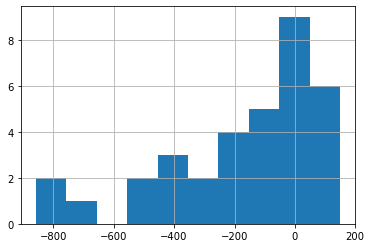

In [ ]:
result_df['sub_regular_reverted'].hist()

In [ ]:
result_df.head()
adhd_people = result_df[result_df.adhd == 'כן']

,age,gender,strong_hand,main_lang,adhd,feel_adhd,brms_rt_mean,brms_rt_mean_regular,brms_rt_mean_reverted,asrs_count,asrs_high_adhd,cpt_response_mean,cpt_response_mean_std,cpt_errors,hps_count
0,23,אישה,ימין,אנגלית,כן,6.0,1464.203571,2927.529670,2936.410952,53.0,1.0,2.703867,3.644434,18.0,9.0
10,30,אישה,ימין,עברית,כן,2.0,1177.673333,2371.826667,2338.866667,38.0,1.0,2.475389,3.351981,2.0,10.0
15,25,אישה,שמאל,עברית,כן,7.0,1514.224138,3043.135715,3014.740000,39.0,1.0,2.608219,3.645885,15.0,10.0
21,24,אישה,שמאל,עברית,כן,7.0,1481.759322,3002.560000,2920.490952,39.0,1.0,2.651503,3.662180,4.0,11.0
34,24,גבר,ימין,עברית,כן,4.0,2526.957627,4634.380000,5492.568095,39.0,1.0,2.617735,3.436059,1.0,10.0


In [ ]:
rho = result_df.corr()
pval = result_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.1,0.05,0.1] if x <=t ]))
rho.round(2).astype(str) + p


NameError: name 'adhd_people' is not defined

<AxesSubplot:>

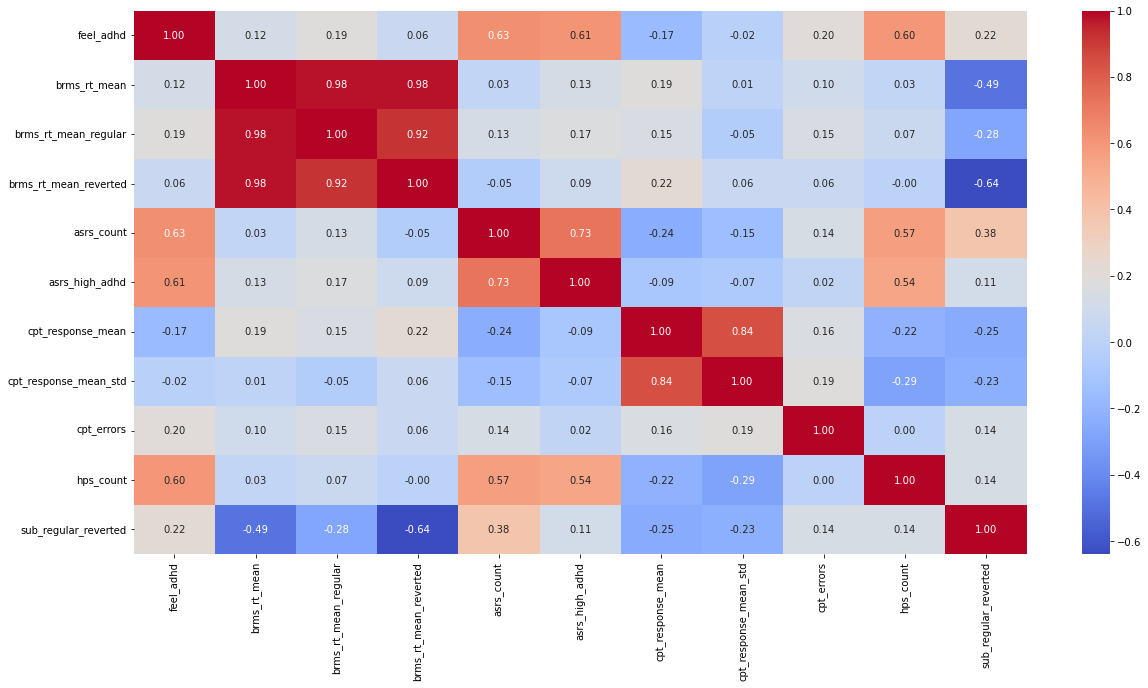

In [ ]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(rho.round(2), annot=True, fmt='.2f', cmap='coolwarm')

In [ ]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

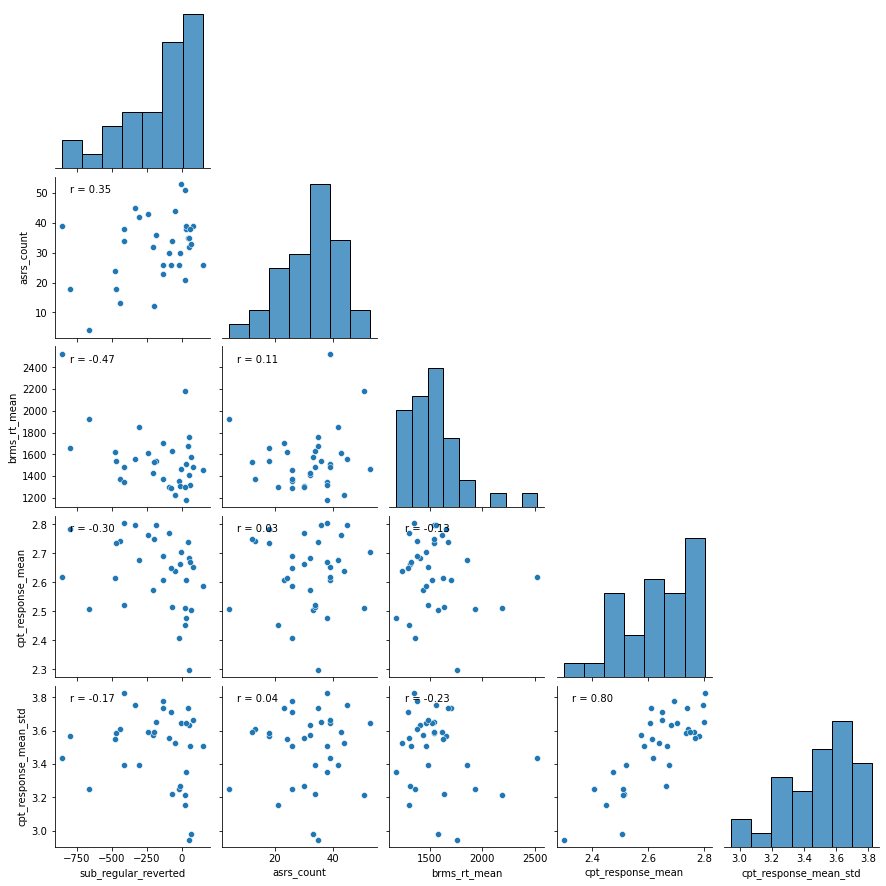

In [ ]:
result_df = result_df[result_df.cpt_response_mean < 3]
graphs = sns.pairplot(result_df[['sub_regular_reverted','asrs_count','brms_rt_mean','cpt_response_mean', 'cpt_response_mean_std']], corner=True)
graphs.map_lower(corrfunc)
plt.show()

In [ ]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [ ]:
reg_m(result_df['sub_regular_reverted'],np.array(result_df[['asrs_count','cpt_response_mean']]).T).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     sub_regular_reverted   R-squared:                       0.224
Model:                              OLS   Adj. R-squared:                  0.174
Method:                   Least Squares   F-statistic:                     4.482
Date:                  Thu, 30 Dec 2021   Prob (F-statistic):             0.0195
Time:                          15:31:26   Log-Likelihood:                -232.44
No. Observations:                    34   AIC:                             470.9
Df Residuals:                        31   BIC:                             475.5
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -660.7667    331.150     -1.995      0.055   -1336.152      14.619
x2             8.5870      3.740      2.296      0.029       0.959      16.215
const       1291.5559    876.826      1.473      0.151    -496.742    3079.854
==============================================================================
Omnibus:                       12.553   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.516
Skew:                          -1.199   Prob(JB):                      0.00192
Kurtosis:                       4.755   Cond. No.                         777.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
result_df.describe()

,feel_adhd,brms_rt_mean,brms_rt_mean_regular,brms_rt_mean_reverted,asrs_count,asrs_high_adhd,cpt_response_mean,cpt_response_mean_std,cpt_errors,hps_count,sub_regular_reverted
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,2.764706,1543.692296,3000.972697,3176.793449,31.676471,0.382353,2.632369,3.494661,4.235294,8.617647,-175.820752
std,1.939366,272.500540,498.017237,617.693443,10.989583,0.493270,0.124126,0.223337,4.383570,2.089145,259.709007
min,0.000000,1177.673333,2371.826667,2338.866667,4.000000,0.000000,2.297436,2.946825,0.000000,4.000000,-858.188095
25%,1.250000,1360.015000,2664.945714,2796.252142,26.000000,0.000000,2.533470,3.362622,2.000000,8.000000,-325.256667
50%,2.000000,1497.991730,2939.274835,3063.460000,33.500000,0.000000,2.650485,3.560195,3.000000,9.000000,-85.897381
75%,4.000000,1629.051132,3159.704881,3335.672427,38.750000,1.000000,2.737580,3.645522,4.000000,10.000000,27.934881
max,7.000000,2526.957627,4634.380000,5492.568095,53.000000,1.000000,2.803400,3.825917,18.000000,12.000000,149.837913


In [ ]:
def plot_with_reggresion_line(df, x, y, x_label, y_label, title, file_name):
    fig = plt.figure(figsize=(20, 10))
    sns.regplot(x=x, y=y, data=df, fit_reg=True, scatter_kws={'alpha': 0.5})
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.savefig(file_name)
    pop_a = mpatches.Patch(label='Correlation: ' + str(round(df[x].corr(df[y]), 2)))
    pop_b = mpatches.Patch(label='P value: ' + str(round(pearsonr(df[x], df[y])[1], 2)))
    plt.legend(handles=[pop_a, pop_b])
    plt.show()


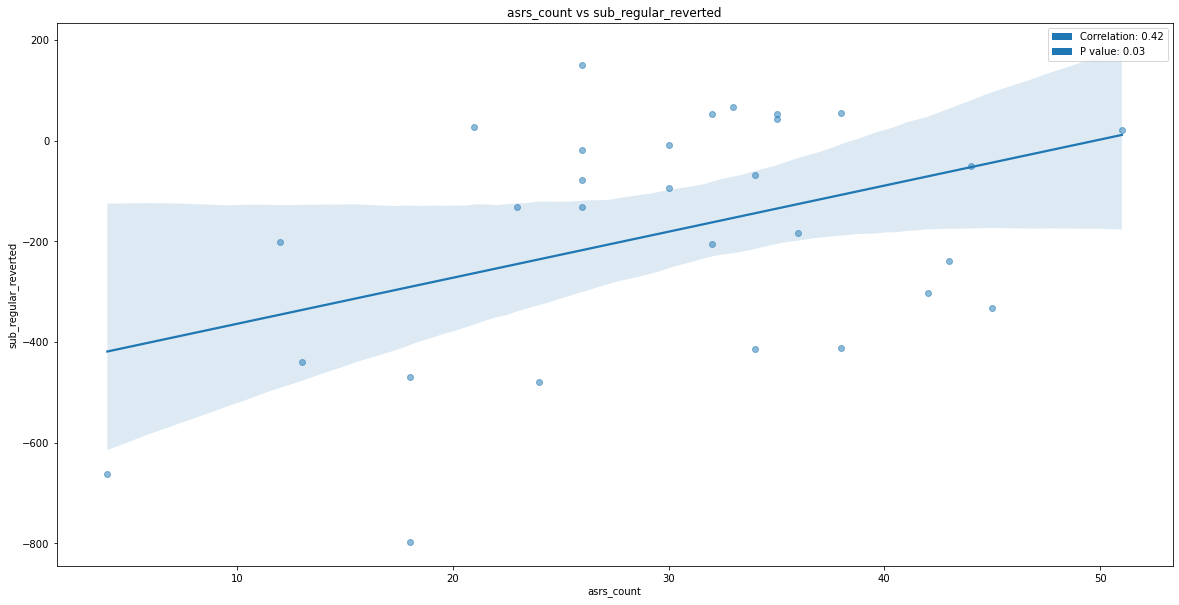

In [ ]:
not_adhd = result_df[result_df.adhd == 'לא']

plot_with_reggresion_line(
    not_adhd,
    'asrs_count', 'sub_regular_reverted',
    'asrs_count', 'sub_regular_reverted',
    'asrs_count vs sub_regular_reverted',
    'asrs_count_vs_sub_regular_reverted.png'
)


In [ ]:
result_df = result_df[result_df.cpt_response_mean < 3]
not_adhd = result_df[result_df.adhd == 'לא']
not_adhd['sub_regular_reverted'] = (not_adhd['brms_rt_mean_regular'] - not_adhd['brms_rt_mean_reverted'])
result_df['sub_regular_reverted'] = (result_df['brms_rt_mean_regular'] - result_df['brms_rt_mean_reverted'])

C:\Users\T-NWEI~1\AppData\Local\Temp/ipykernel_18028/1847711784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_adhd['sub_regular_reverted'] = (not_adhd['brms_rt_mean_regular'] - not_adhd['brms_rt_mean_reverted'])


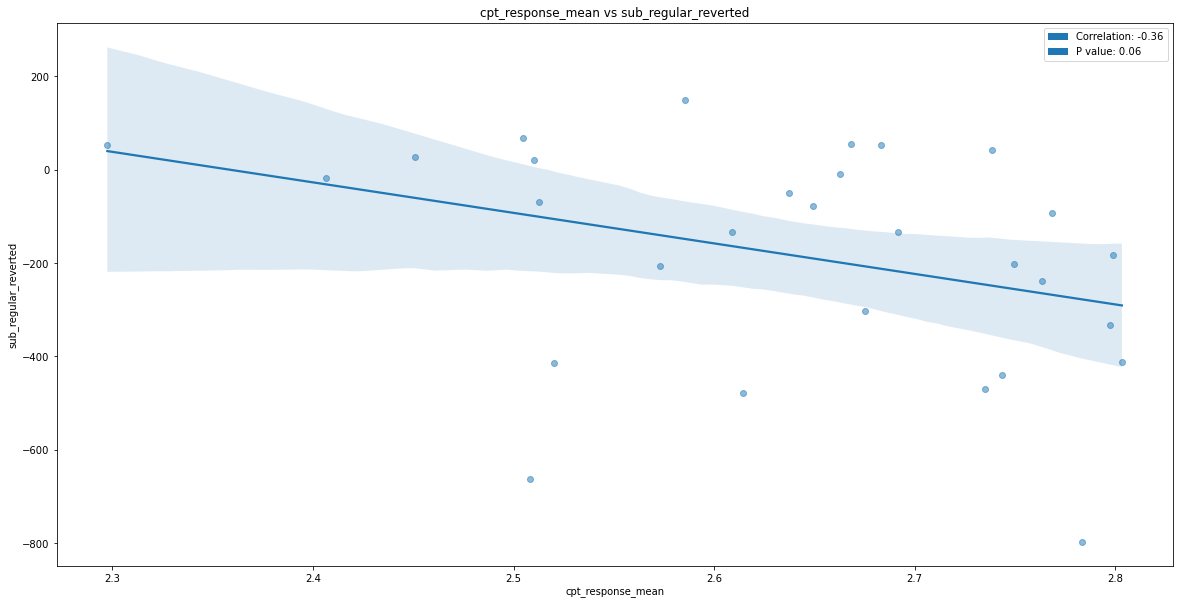

In [ ]:
plot_with_reggresion_line(
    not_adhd,
    'cpt_response_mean', 'sub_regular_reverted',
    'cpt_response_mean', 'sub_regular_reverted',
    'cpt_response_mean vs sub_regular_reverted', 'cpt_response_mean_vs_sub_regular_reverted.png'
)


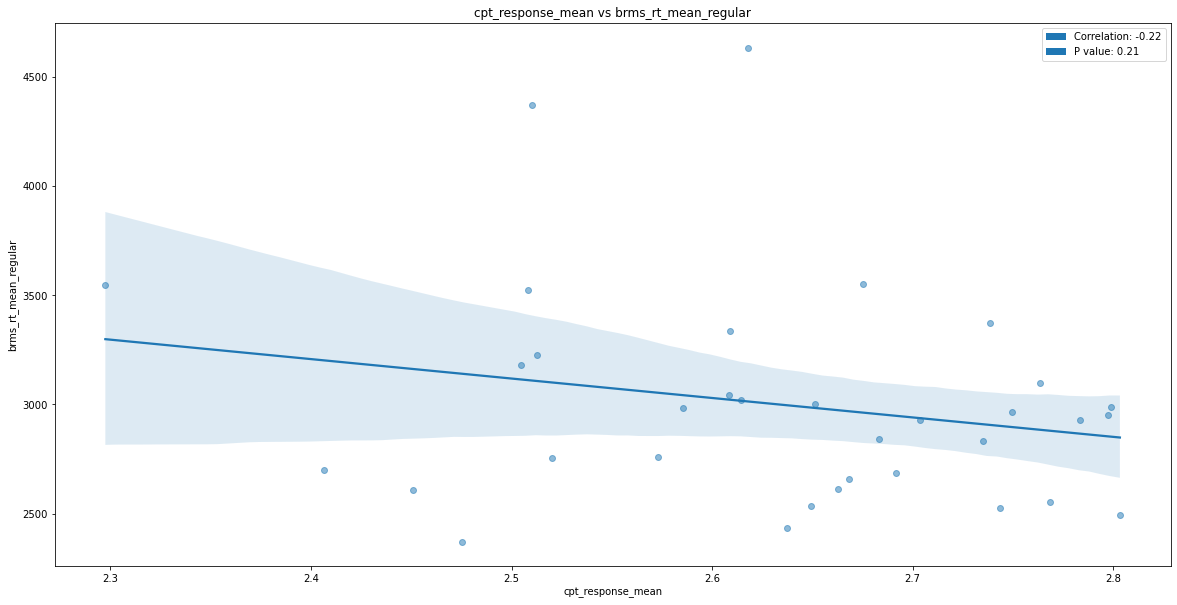

In [ ]:
plot_with_reggresion_line(
    result_df,
    'cpt_response_mean', 'brms_rt_mean_regular',
    'cpt_response_mean', 'brms_rt_mean_regular',
    'cpt_response_mean vs brms_rt_mean_regular',
    'cpt_response_mean_vs_brms_rt_mean_regular.png'
)

In [ ]:
result_df.describe()

,feel_adhd,brms_rt_mean,brms_rt_mean_regular,brms_rt_mean_reverted,asrs_count,asrs_high_adhd,cpt_response_mean,cpt_response_mean_std,cpt_errors,hps_count
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,2.685714,1555.175321,3020.744443,3203.359643,31.171429,0.371429,2.691848,3.529648,4.342857,8.542857
std,1.966954,276.925302,504.389429,628.510116,11.231483,0.490241,0.372526,0.302086,4.365256,2.105216
min,0.000000,1177.673333,2371.826667,2338.866667,4.000000,0.000000,2.297436,2.946825,0.000000,4.000000
25%,1.000000,1364.723333,2671.447326,2803.184285,25.000000,0.000000,2.546696,3.373262,2.000000,7.500000
50%,2.000000,1514.224138,2951.020000,3112.180000,33.000000,0.000000,2.651503,3.567180,3.000000,9.000000
75%,4.000000,1643.039261,3203.398809,3404.021428,38.500000,1.000000,2.740943,3.649430,4.000000,10.000000
max,7.000000,2526.957627,4634.380000,5492.568095,53.000000,1.000000,4.714133,4.719213,18.000000,12.000000


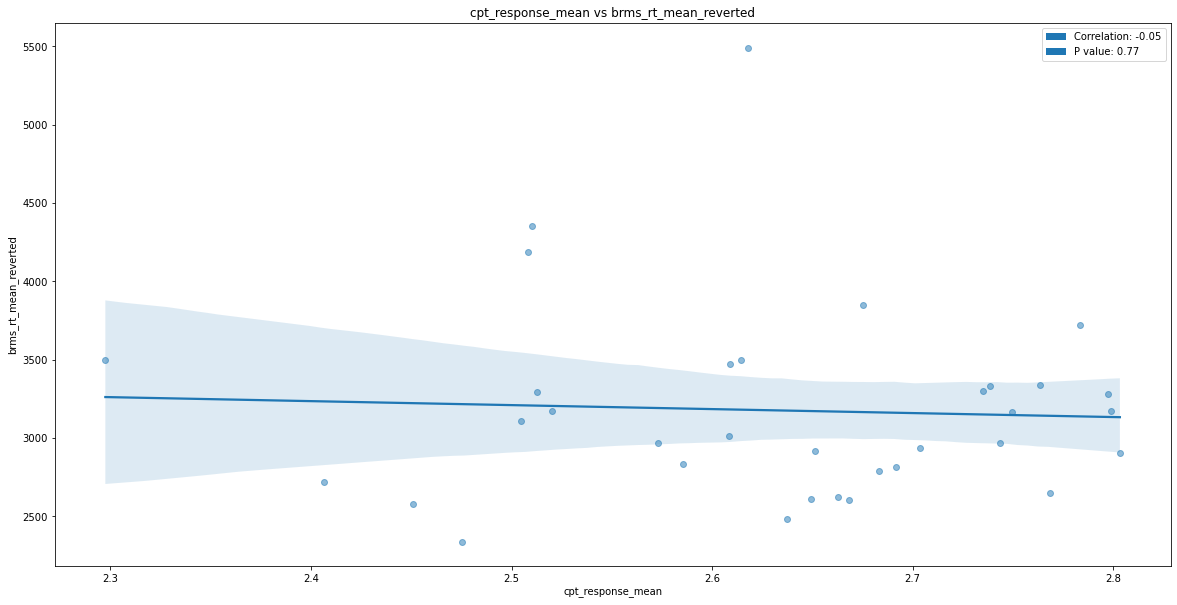

In [ ]:
plot_with_reggresion_line(
    result_df,
    'cpt_response_mean', 'brms_rt_mean_reverted',
    'cpt_response_mean', 'brms_rt_mean_reverted',
    'cpt_response_mean vs brms_rt_mean_reverted',
    'cpt_response_mean_vs_brms_rt_mean_regular.png'
)

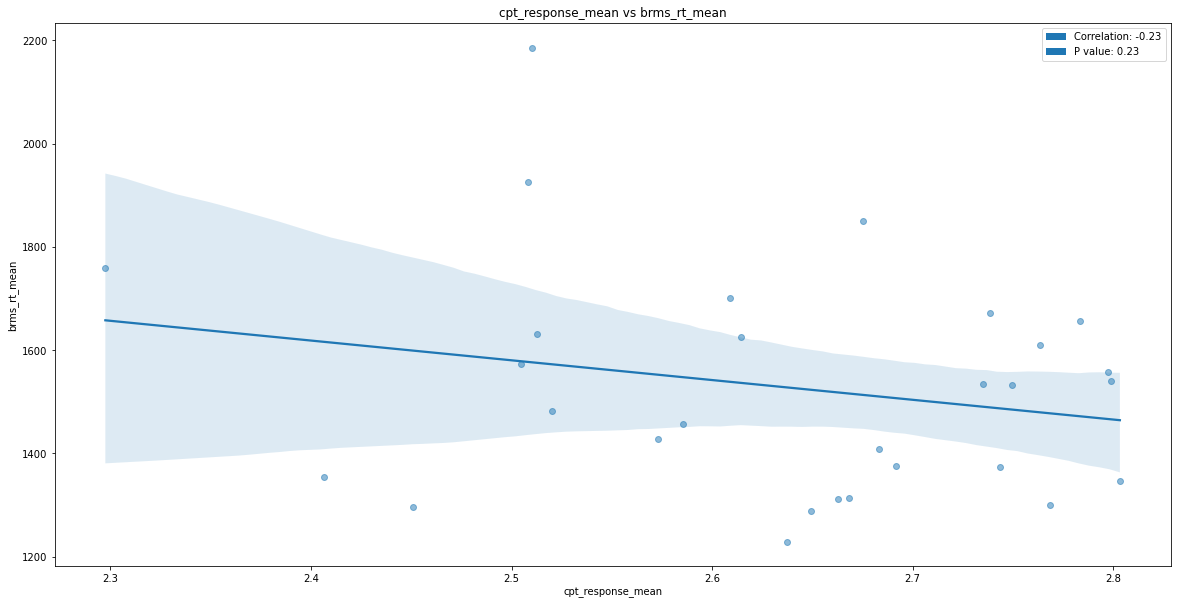

In [ ]:
plot_with_reggresion_line(
    not_adhd,
    'cpt_response_mean', 'brms_rt_mean',
    'cpt_response_mean', 'brms_rt_mean',
    'cpt_response_mean vs brms_rt_mean',
    'cpt_response_mean_vs_brms_rt_mean.png'
)

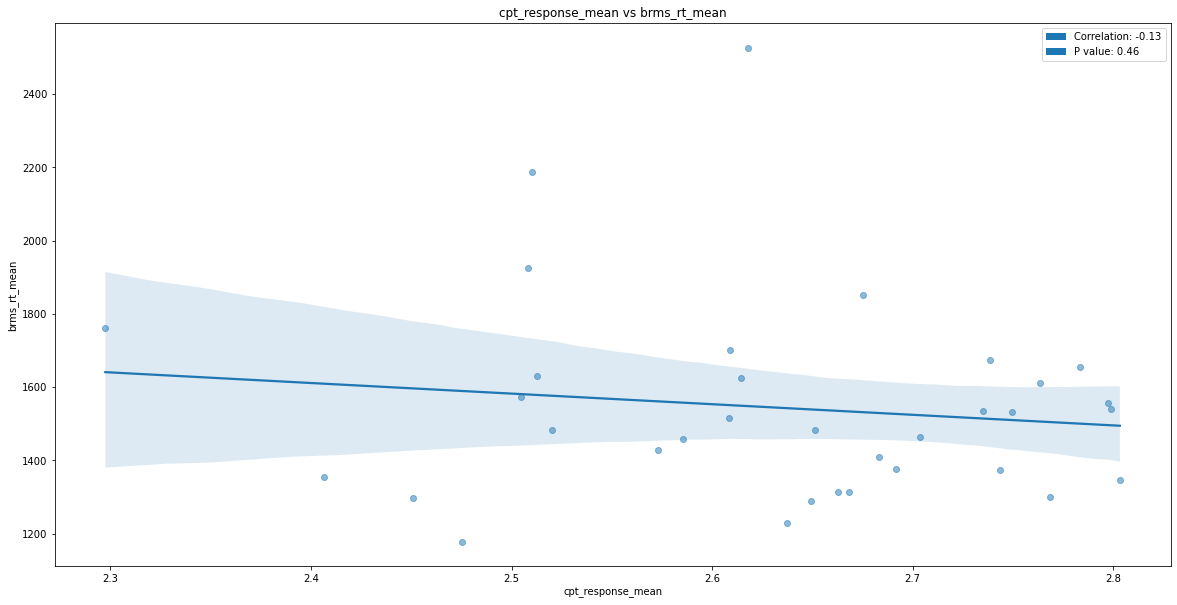

In [ ]:
plot_with_reggresion_line(
    result_df,
    'cpt_response_mean', 'brms_rt_mean',
    'cpt_response_mean', 'brms_rt_mean',
    'cpt_response_mean vs brms_rt_mean',
    'cpt_response_mean_vs_brms_rt_mean.png'
)


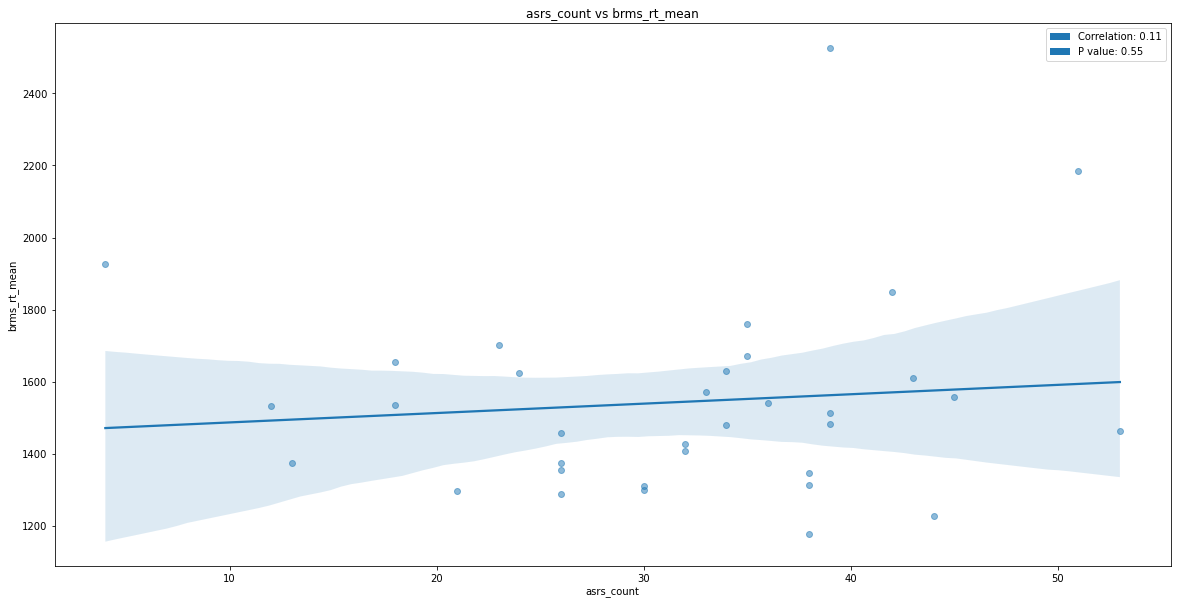

In [ ]:
plot_with_reggresion_line(
    result_df,
    'asrs_count', 'brms_rt_mean',
    'asrs_count', 'brms_rt_mean',
    'asrs_count vs brms_rt_mean',
    'asrs_count_vs_brms_rt_mean.png'
)

<AxesSubplot:>

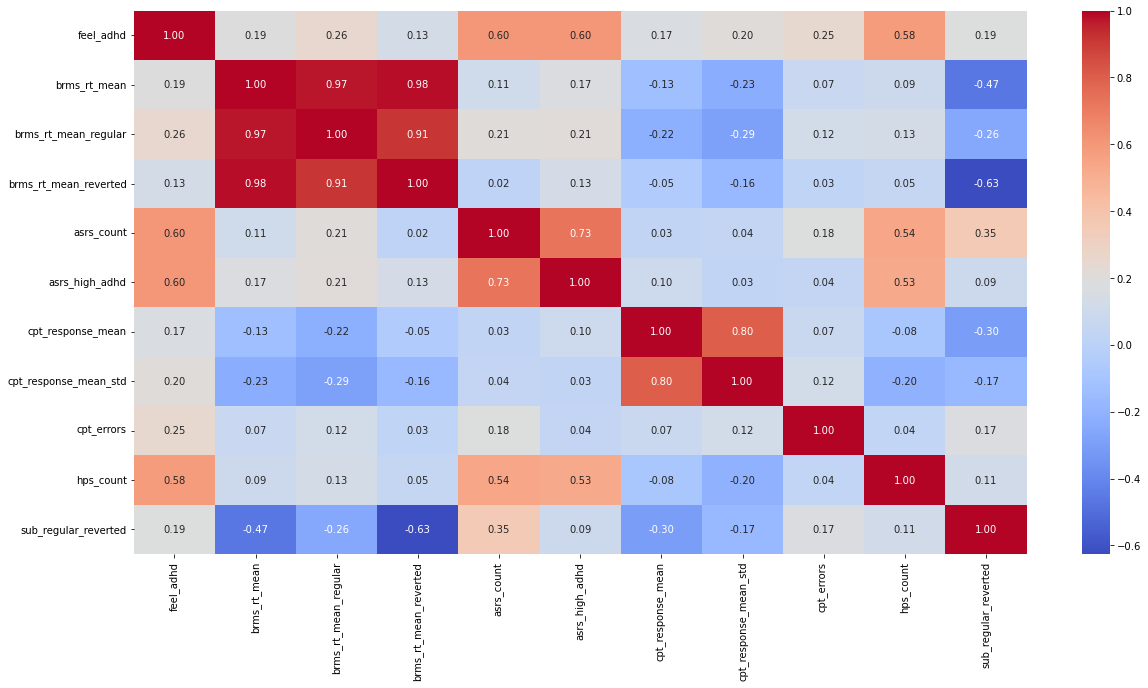

In [ ]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(result_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [ ]:
def get_cpt_graphs(is_standard = False, is_log = False):
    all_df = []

    for single_df in df_lst:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        if is_standard:
            cpt_result = get_standards_cpt_result(single_df, is_log)
        else:
            cpt_result = get_cpt_resuslt(single_df, is_log)
        all_df.append(cpt_result)
        plt.xlabel('cpt result')
        plt.ylabel('count')
        plt.xticks(np.arange(0, 100, 1))
        plt.hist(cpt_result)
        plt.show()

    cpt_df = pd.concat(all_df)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

    plt.xlabel('cpt result')
    plt.ylabel('count')
    plt.xticks(np.arange(0, 100, 1))
    plt.hist(cpt_df)
    plt.show()
    
# get_cpt_graphs(is_standard = True)


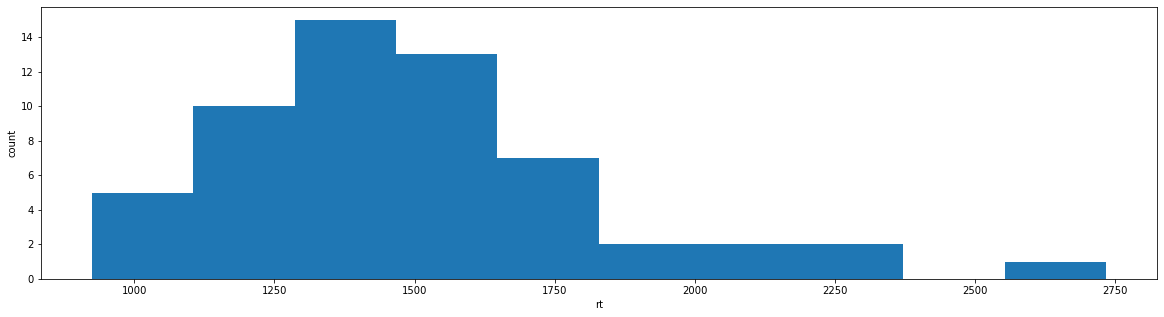

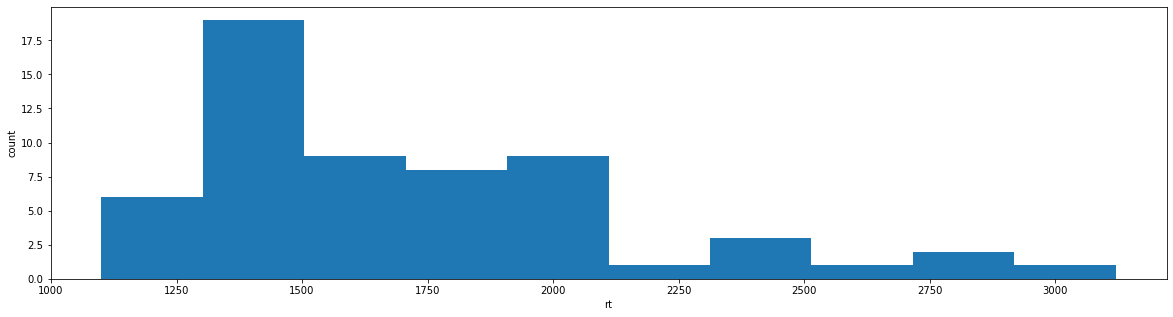

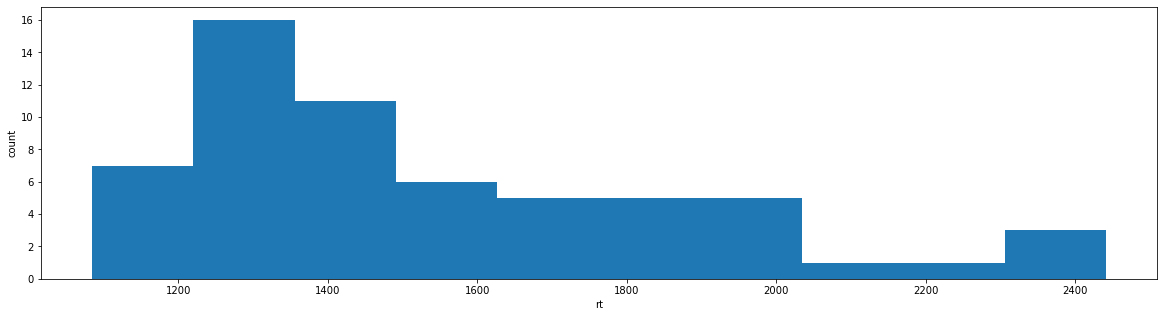

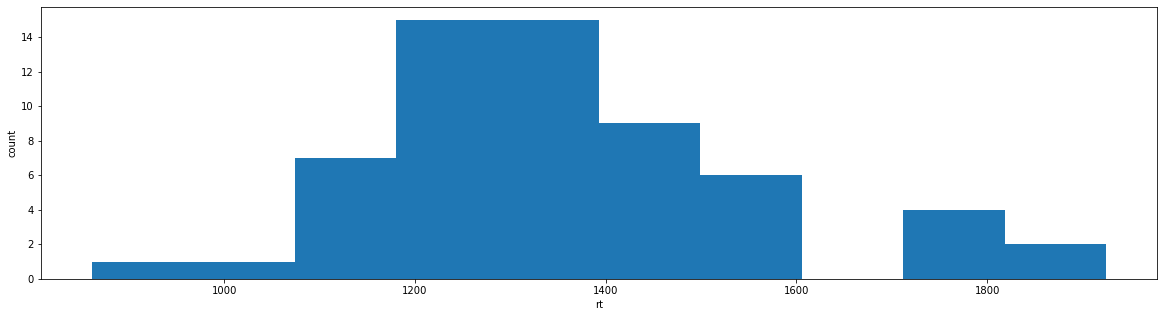

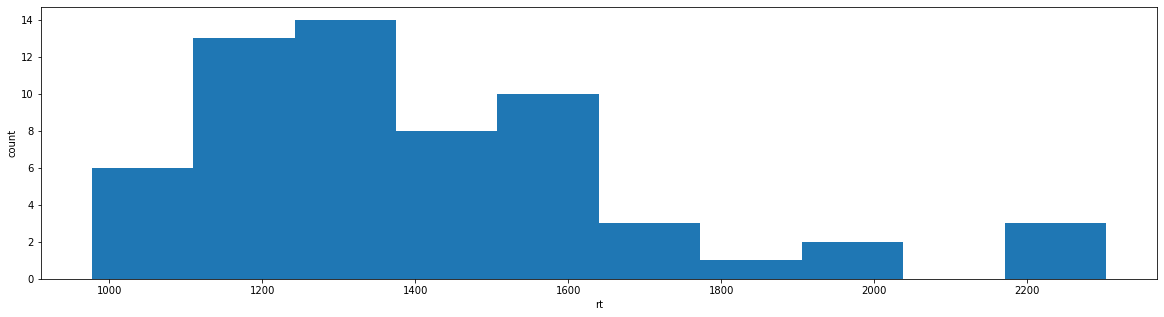

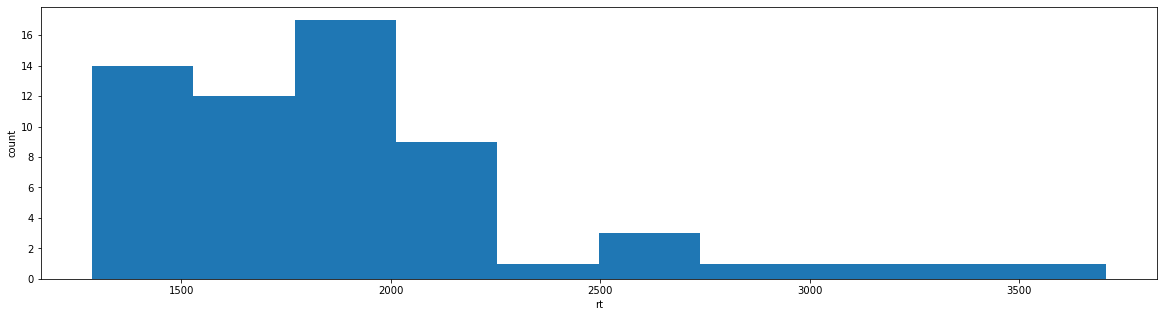

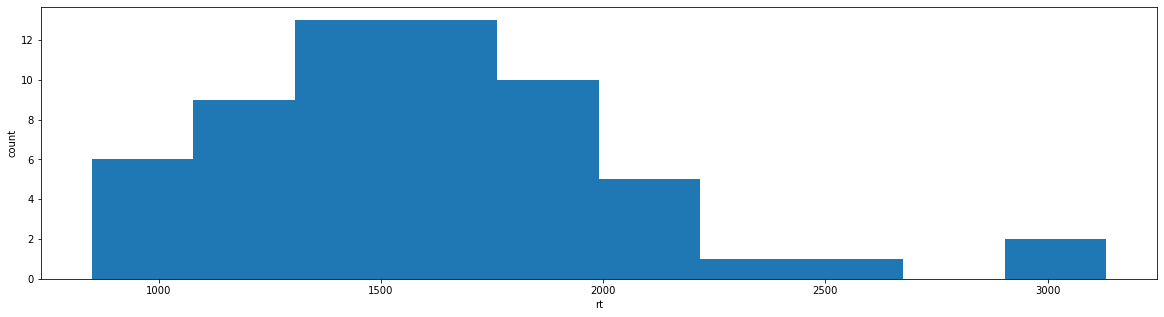

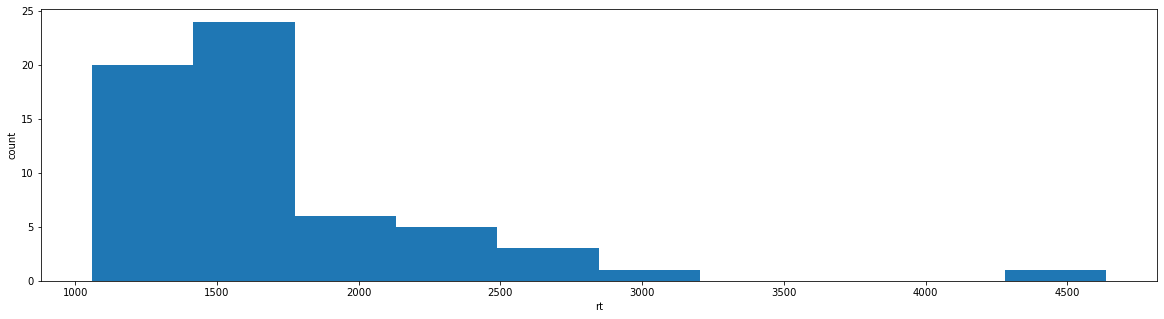

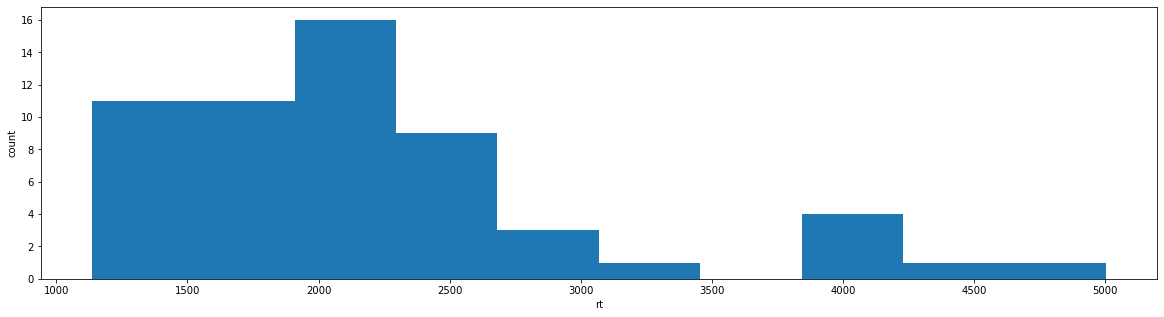

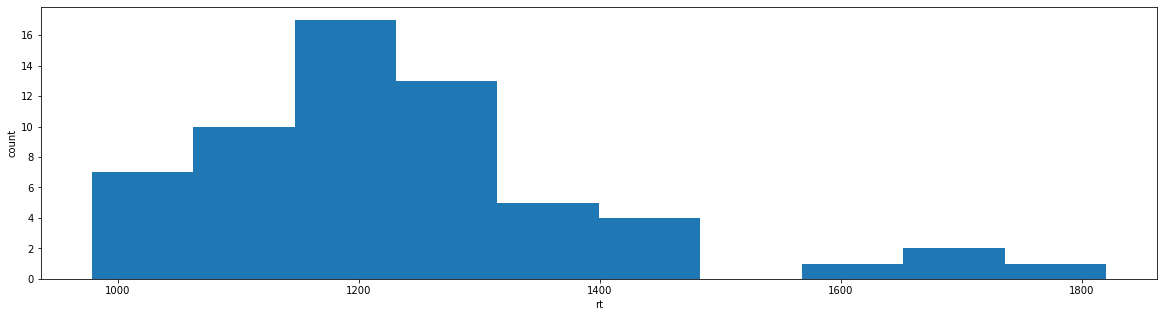

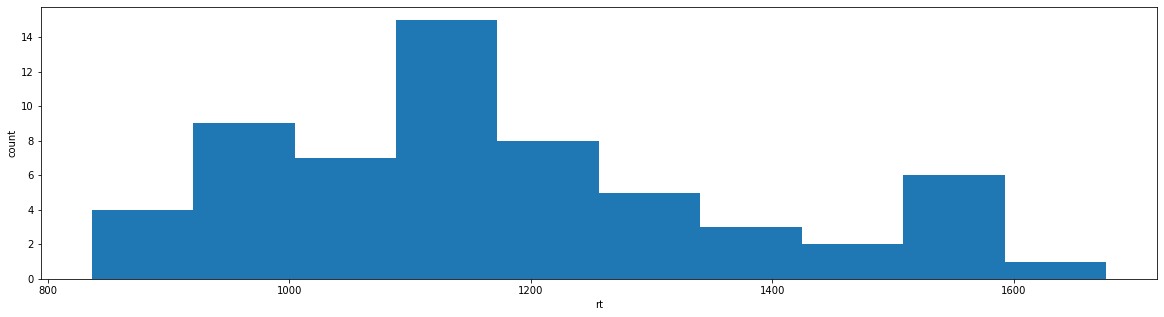

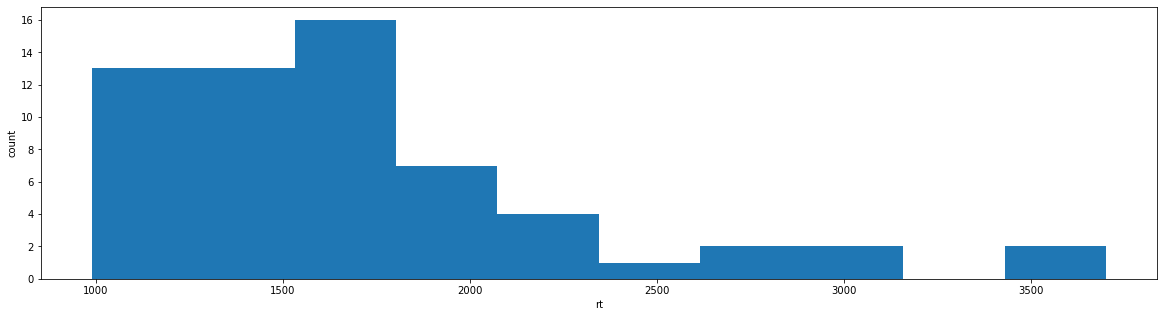

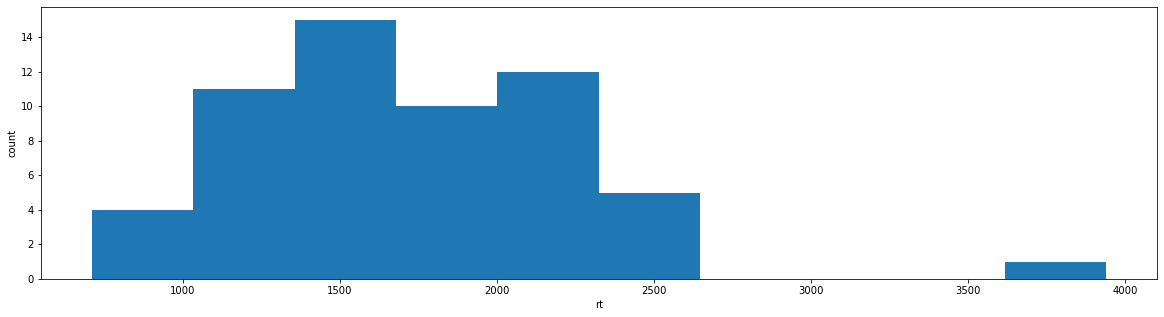

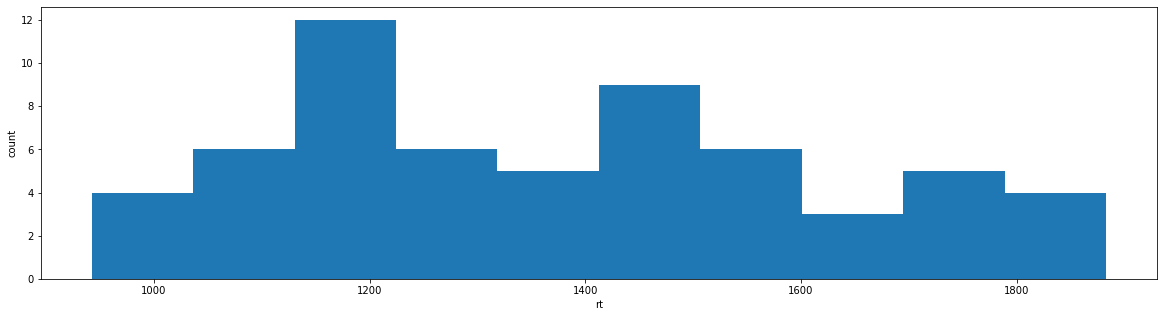

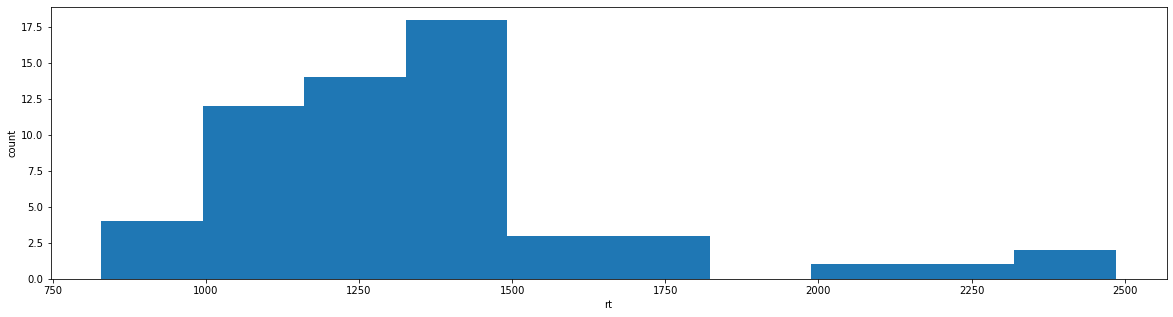

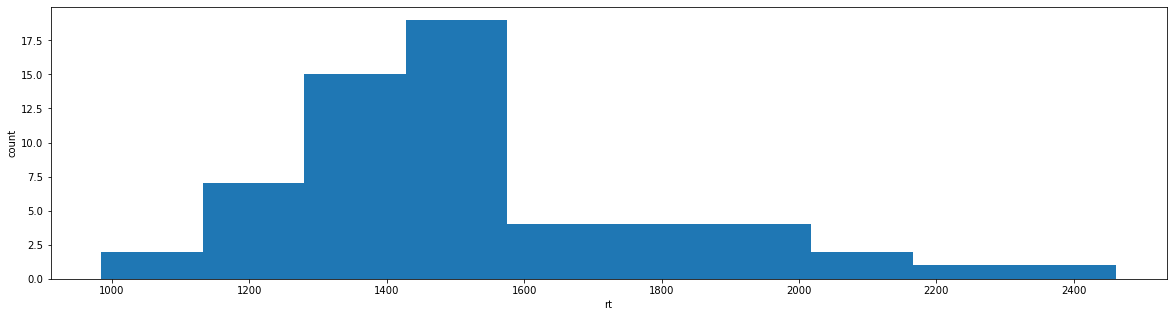

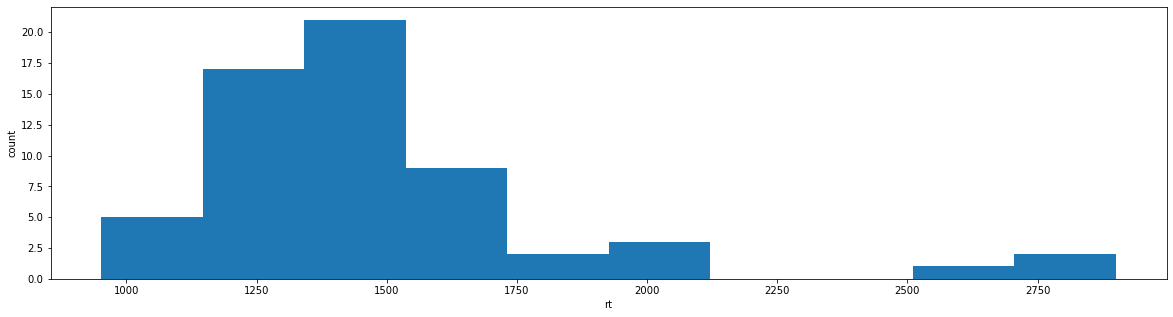

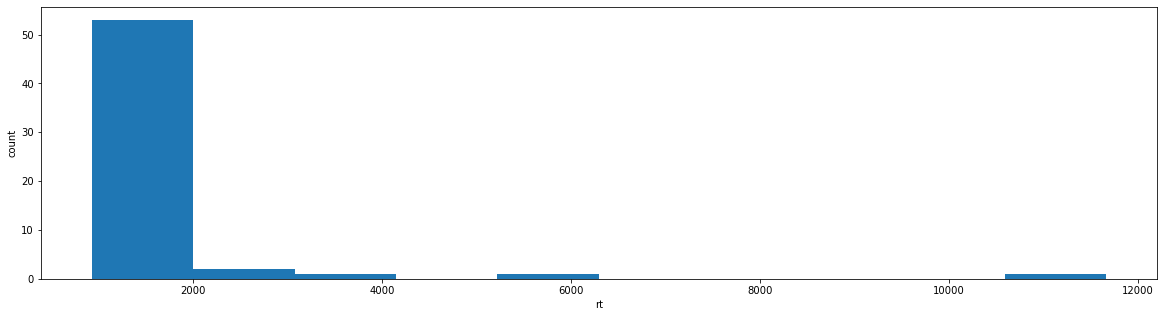

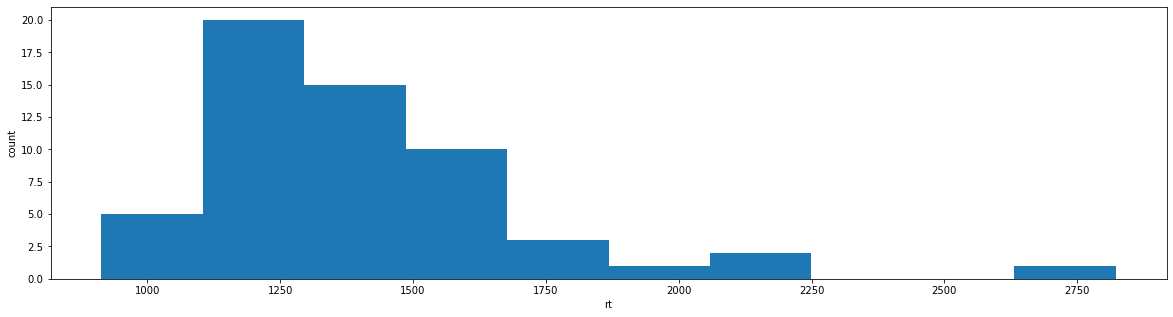

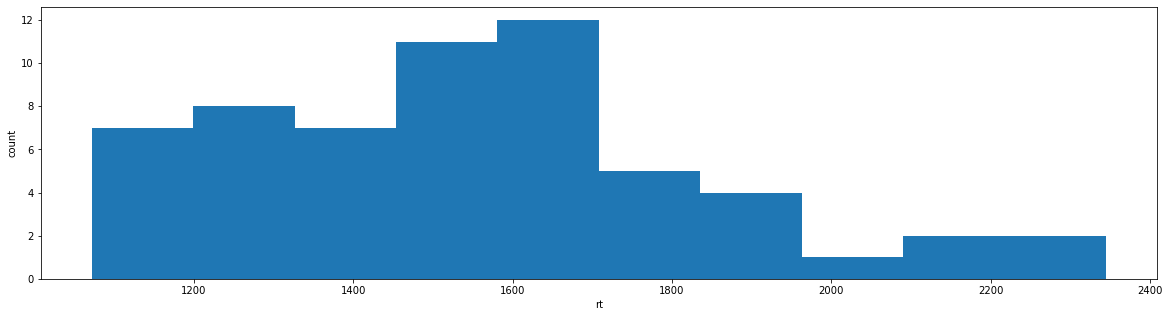

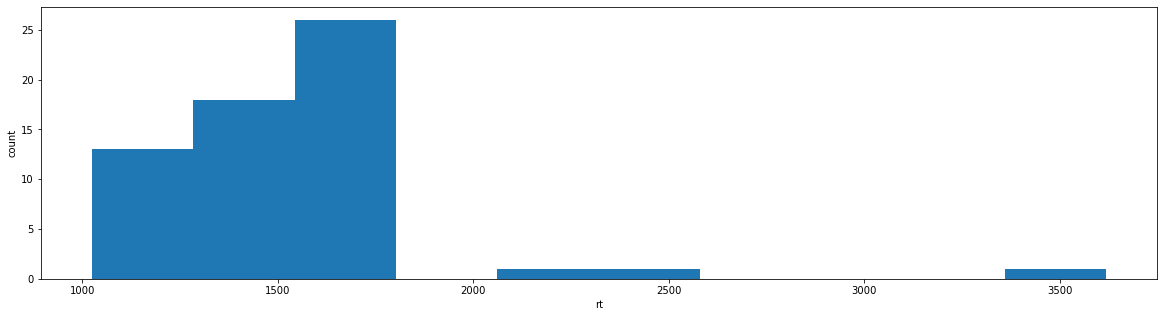

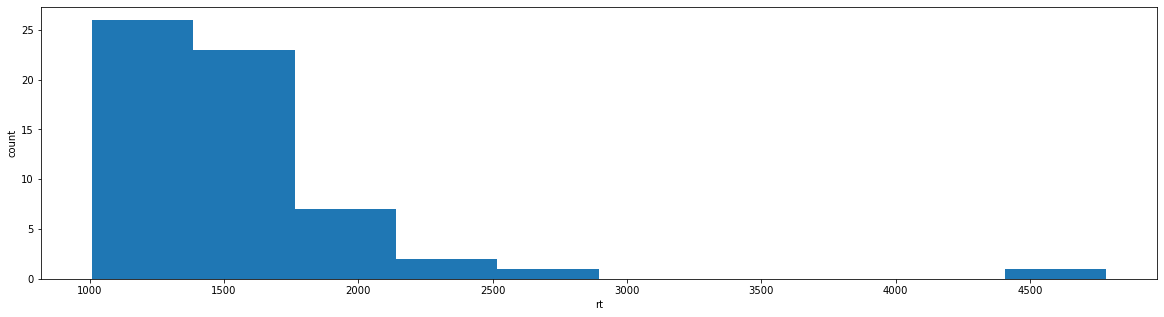

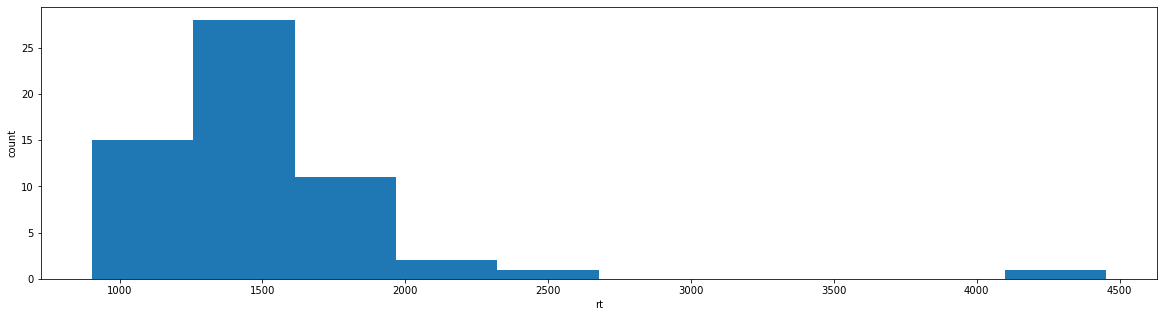

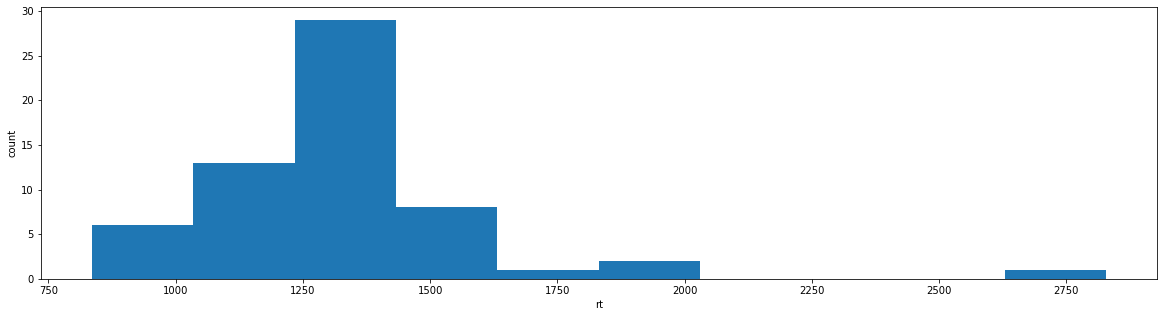

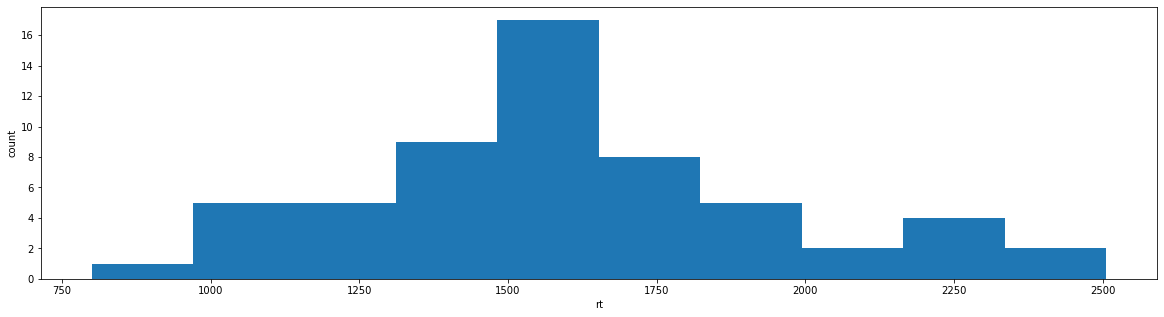

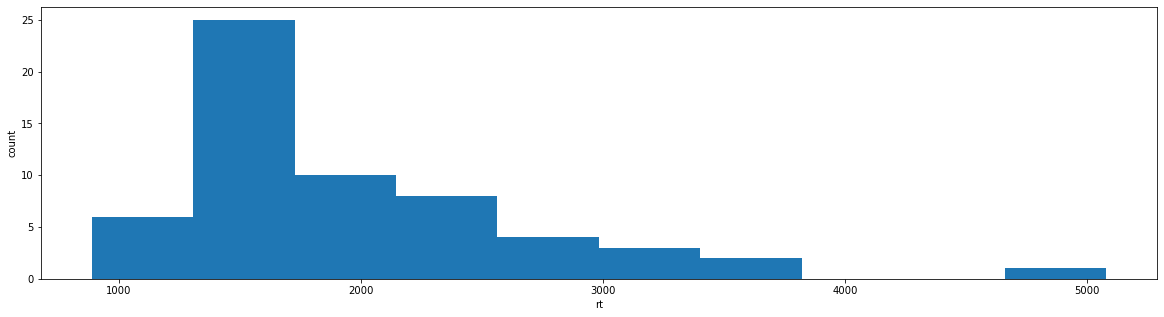

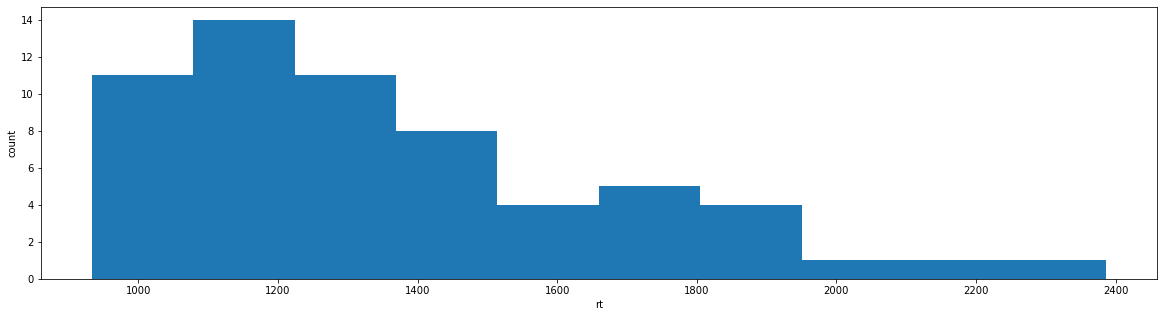

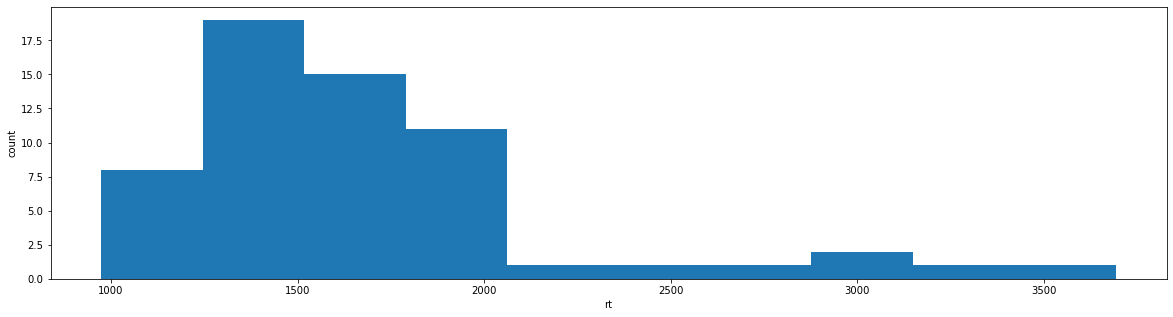

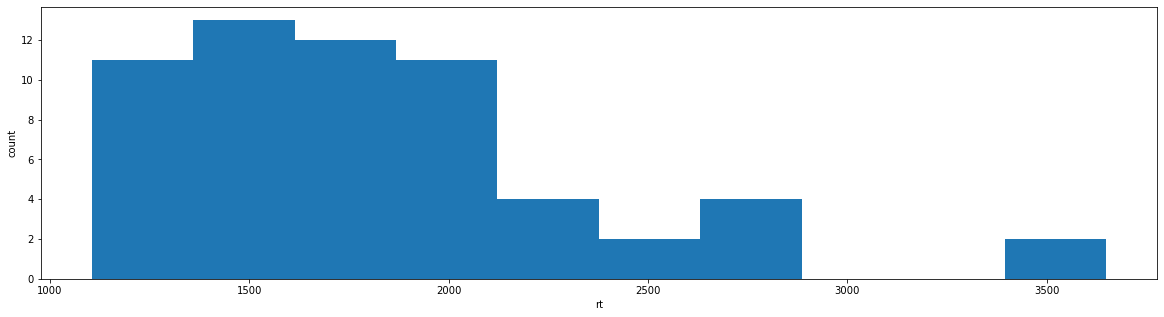

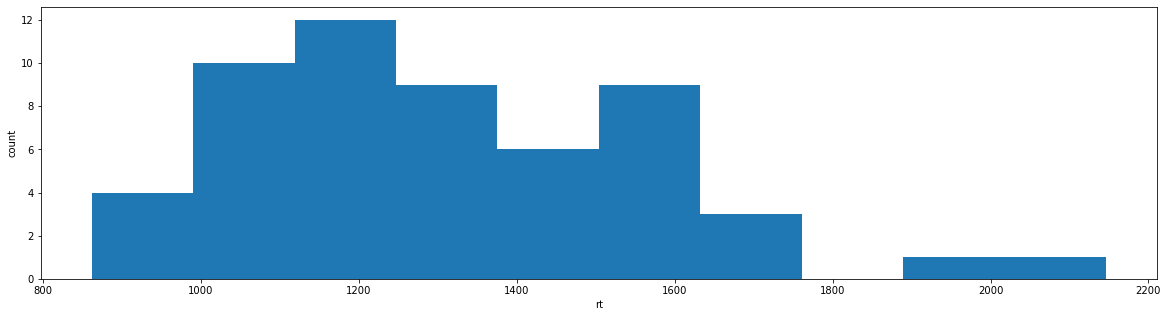

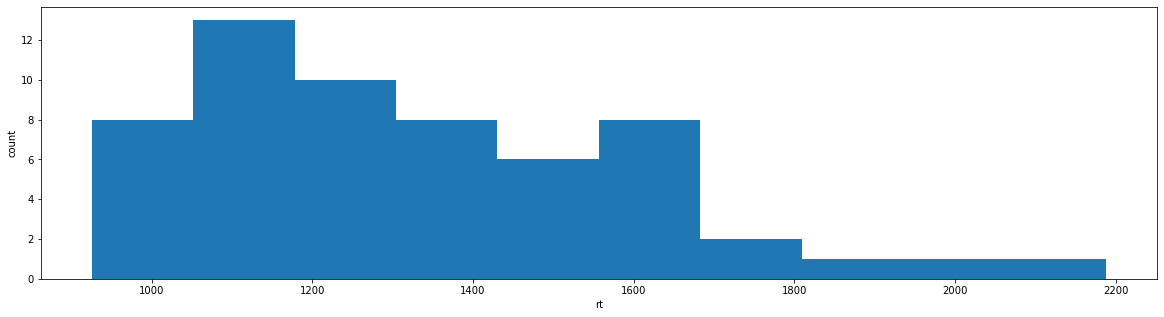

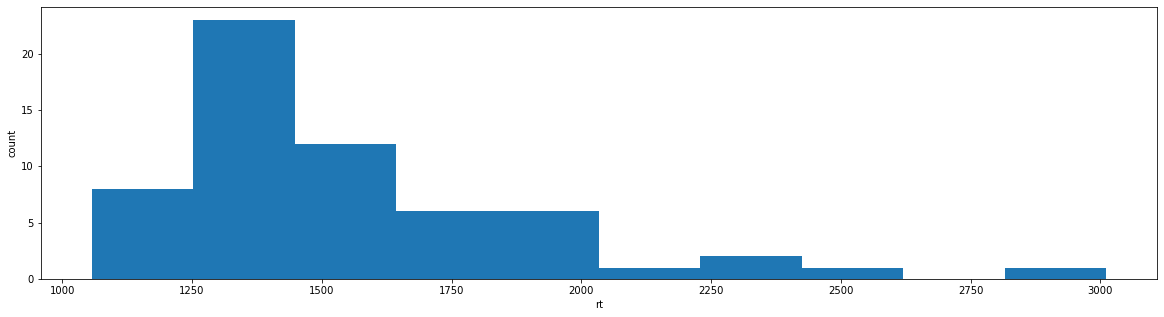

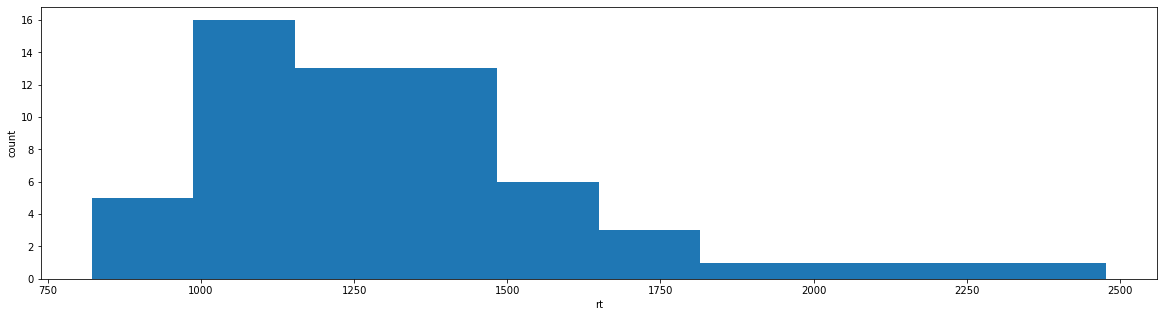

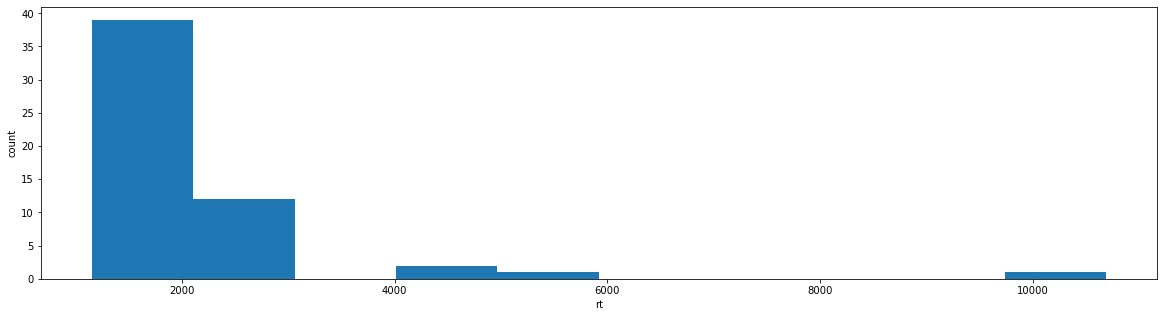

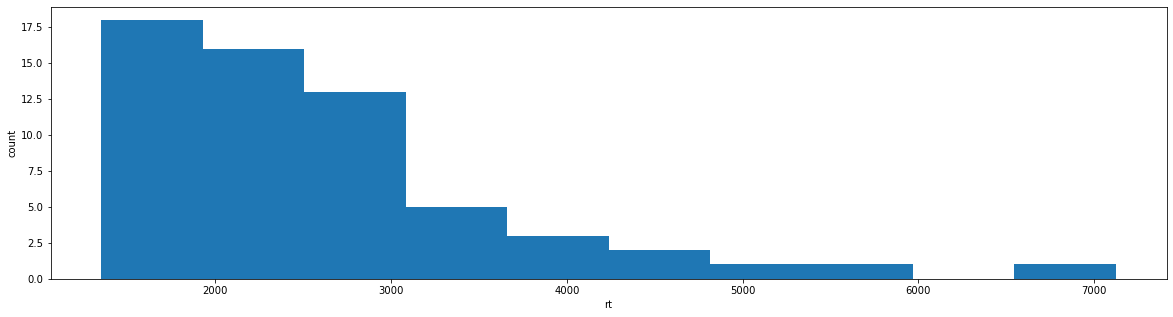

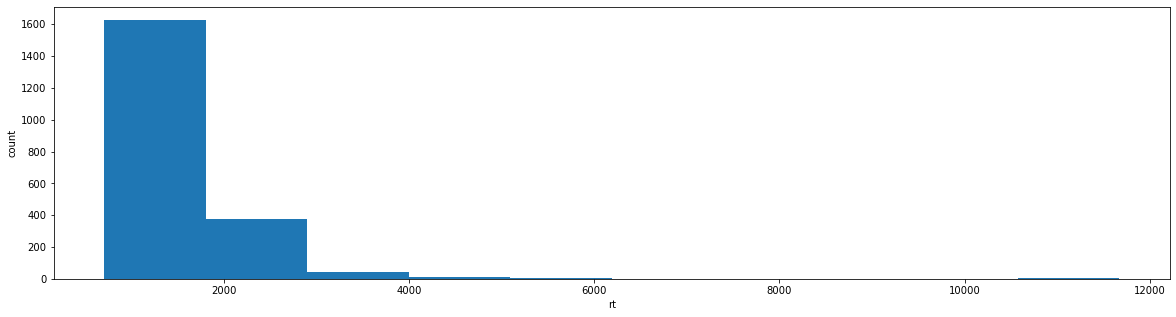

In [ ]:
def get_rms_graphs(is_standard=False, is_log=False):
    all_df = []

    for single_df in df_lst:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

        brms_df = get_brms_df(single_df, False)
        if is_standard:
            brms_df = get_rms_standards(single_df)
        all_df.append(brms_df)
        plt.xlabel("rt")
        plt.ylabel("count")
        plt.hist(brms_df.rt)
        plt.show()

    brms_df = pd.concat(all_df)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

    plt.xlabel('rt')
    plt.ylabel('count')
    plt.hist(brms_df.rt)
    plt.show()
        
get_rms_graphs(is_standard=False)


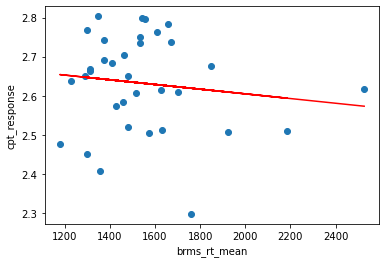

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_mean.values.reshape(-1, 1)
Y = result_df.cpt_response_mean.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_mean")
plt.ylabel("cpt_response")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_mean.values.reshape(-1, 1)
Y = result_df.cpt_response_sd.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_mean")
plt.ylabel("cpt_response_sd")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'cpt_response_sd'

AttributeError: 'DataFrame' object has no attribute 'asrs_1_count'

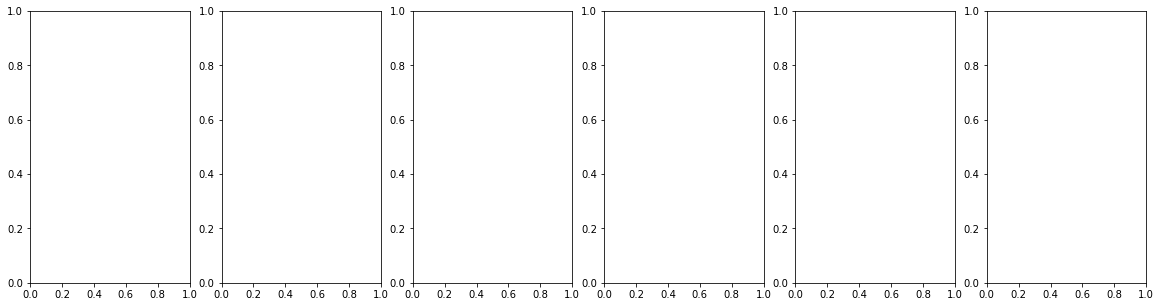

In [ ]:
from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

X = result_df.brms_rt_mean.values.reshape(-1, 1)

Y_1 = result_df.asrs_1_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_1_pred = linear_regressor.predict(X)

axes[0].scatter(X, Y)
axes[0].plot(X, Y_pred, color='red')
axes[0].set_xlabel("brms_rt_mean")
axes[0].set_ylabel("asrs_1_count")

Y_2 = result_df.asrs_2_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_2_pred = linear_regressor.predict(X)

axes[1].scatter(X, Y_2)
axes[1].plot(X, Y_2_pred, color='red')
axes[1].set_xlabel("brms_rt_mean")
axes[1].set_ylabel("asrs_2_count")

Y_3 = result_df.cpt_response_mean.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_3_pred = linear_regressor.predict(X)

axes[2].scatter(X, Y_3)
axes[2].plot(X, Y_3_pred, color='red')
axes[2].set_xlabel("brms_rt_mean")
axes[2].set_ylabel("cpt_response_mean")

Y_4 = result_df.cpt_response_sd.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_4_pred = linear_regressor.predict(X)

axes[3].scatter(X, Y_4)
axes[3].plot(X, Y_4_pred, color='red')
axes[3].set_xlabel("brms_rt_mean")
axes[3].set_ylabel("cpt_response_sd")

plt.show()

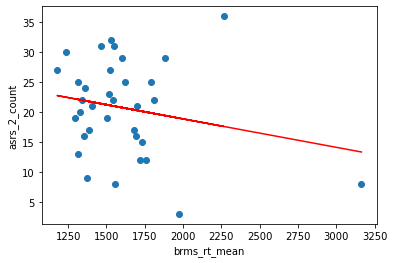

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_mean.values.reshape(-1, 1)
Y = result_df.asrs_2_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_mean")
plt.ylabel("asrs_2_count")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

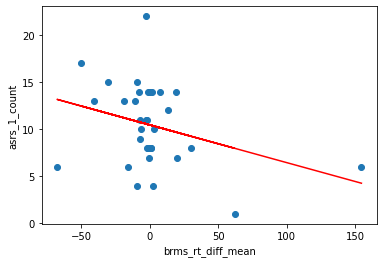

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_diff_mean.values.reshape(-1, 1)
Y = result_df.asrs_1_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_diff_mean")
plt.ylabel("asrs_1_count")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

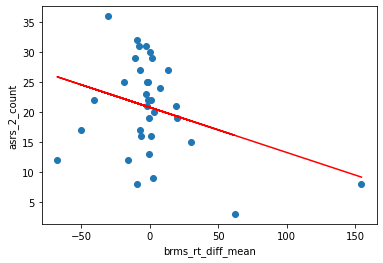

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_diff_mean.values.reshape(-1, 1)
Y = result_df.asrs_2_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_diff_mean")
plt.ylabel("asrs_2_count")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

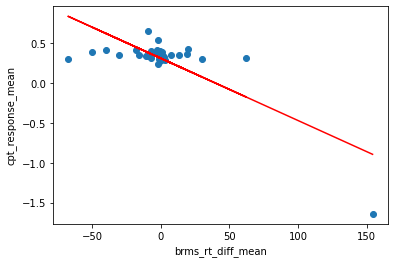

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_diff_mean.values.reshape(-1, 1)
Y = result_df.cpt_response_mean.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_diff_mean")
plt.ylabel("cpt_response_mean")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

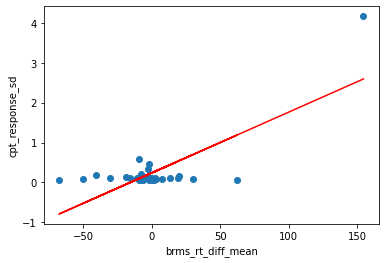

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_diff_mean.values.reshape(-1, 1)
Y = result_df.cpt_response_sd.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_diff_mean")
plt.ylabel("cpt_response_sd")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

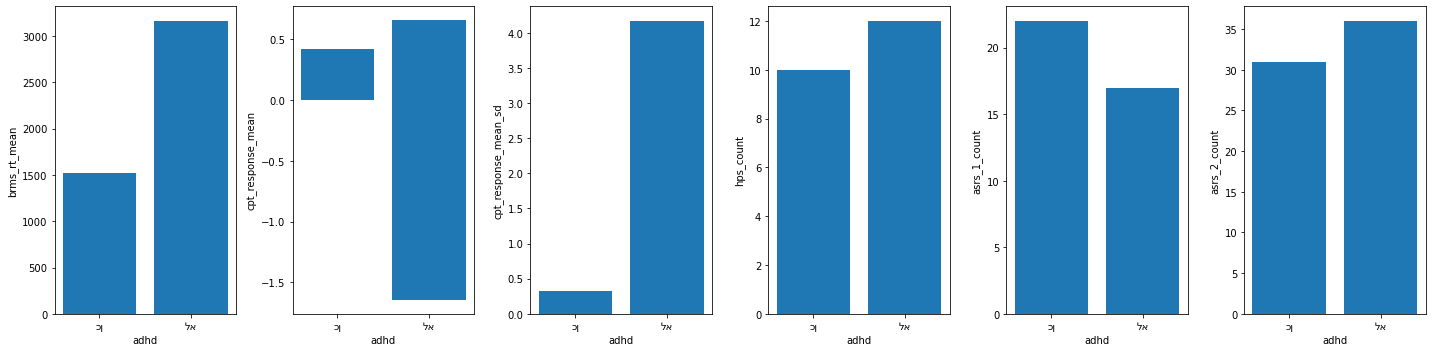

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

axes[0].bar(result_df.adhd, result_df.brms_rt_mean)
axes[0].set_xlabel("adhd")
axes[0].set_ylabel("brms_rt_mean")

axes[1].bar(result_df.adhd, result_df.cpt_response_mean)
axes[1].set_xlabel("adhd")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.adhd, result_df.cpt_response_sd)
axes[2].set_xlabel("adhd")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.adhd, result_df.hps_count)
axes[3].set_xlabel("adhd")
axes[3].set_ylabel("hps_count")
fig.tight_layout(),

axes[4].bar(result_df.adhd, result_df.asrs_1_count)
axes[4].set_xlabel("adhd")
axes[4].set_ylabel("asrs_1_count")
fig.tight_layout()

axes[5].bar(result_df.adhd, result_df.asrs_2_count)
axes[5].set_xlabel("adhd")
axes[5].set_ylabel("asrs_2_count")
fig.tight_layout()

plt.show()

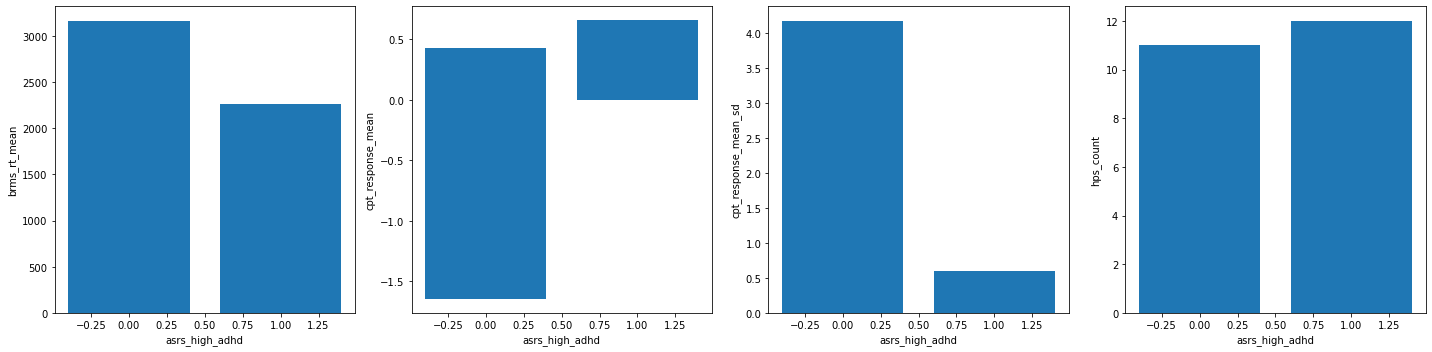

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axes[0].bar(result_df.asrs_high_adhd, result_df.brms_rt_mean)
axes[0].set_xlabel("asrs_high_adhd")
axes[0].set_ylabel("brms_rt_mean")

axes[1].bar(result_df.asrs_high_adhd, result_df.cpt_response_mean)
axes[1].set_xlabel("asrs_high_adhd")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.asrs_high_adhd, result_df.cpt_response_sd)
axes[2].set_xlabel("asrs_high_adhd")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.asrs_high_adhd, result_df.hps_count)
axes[3].set_xlabel("asrs_high_adhd")
axes[3].set_ylabel("hps_count")
fig.tight_layout()

plt.show()

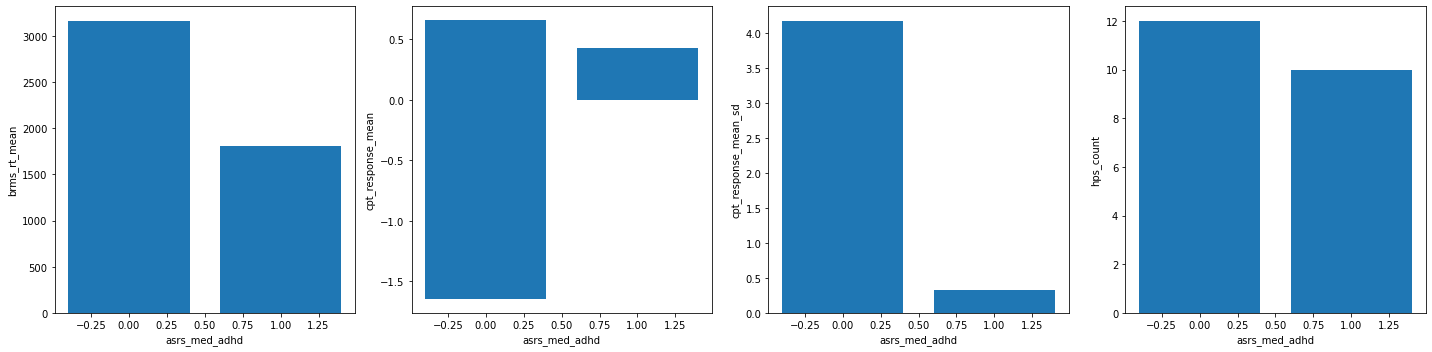

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axes[0].bar(result_df.asrs_med_adhd, result_df.brms_rt_mean)
axes[0].set_xlabel("asrs_med_adhd")
axes[0].set_ylabel("brms_rt_mean")

axes[1].bar(result_df.asrs_med_adhd, result_df.cpt_response_mean)
axes[1].set_xlabel("asrs_med_adhd")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.asrs_med_adhd, result_df.cpt_response_sd)
axes[2].set_xlabel("asrs_med_adhd")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.asrs_med_adhd, result_df.hps_count)
axes[3].set_xlabel("asrs_med_adhd")
axes[3].set_ylabel("hps_count")
fig.tight_layout()

plt.show()

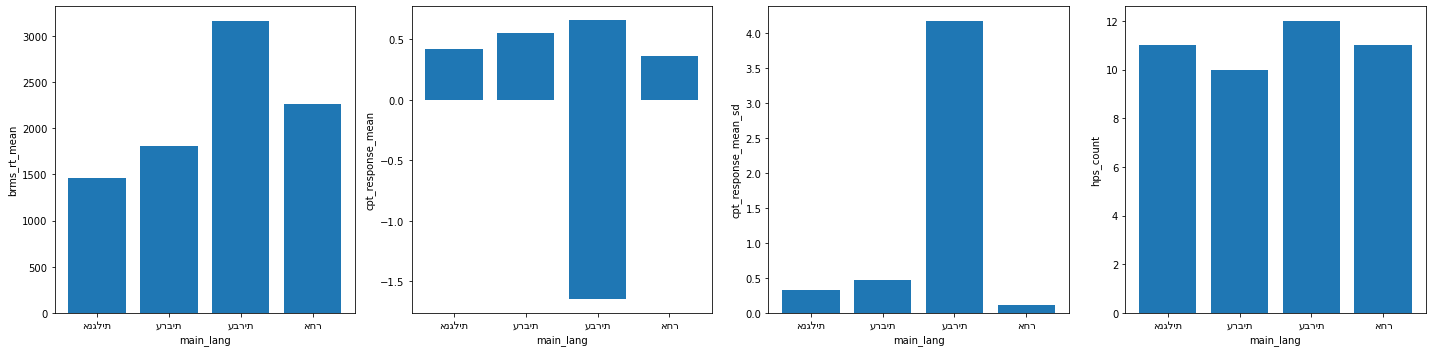

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axes[0].bar(result_df.main_lang, result_df.brms_rt_mean)
axes[0].set_xlabel("main_lang")
axes[0].set_ylabel("brms_rt_mean")
fig.tight_layout()

axes[1].bar(result_df.main_lang, result_df.cpt_response_mean)
axes[1].set_xlabel("main_lang")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.main_lang, result_df.cpt_response_sd)
axes[2].set_xlabel("main_lang")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.main_lang, result_df.hps_count)
axes[3].set_xlabel("main_lang")
axes[3].set_ylabel("hps_count")
fig.tight_layout()

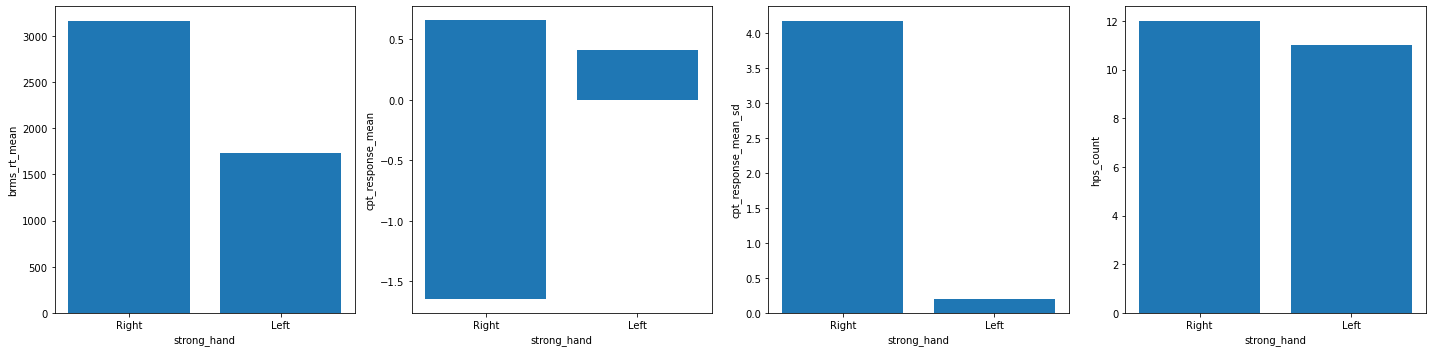

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axes[0].bar(result_df.strong_hand, result_df.brms_rt_mean)
axes[0].set_xlabel("strong_hand")
axes[0].set_ylabel("brms_rt_mean")
fig.tight_layout()

axes[1].bar(result_df.strong_hand, result_df.cpt_response_mean)
axes[1].set_xlabel("strong_hand")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.strong_hand, result_df.cpt_response_sd)
axes[2].set_xlabel("strong_hand")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.strong_hand, result_df.hps_count)
axes[3].set_xlabel("strong_hand")
axes[3].set_ylabel("hps_count")
fig.tight_layout()

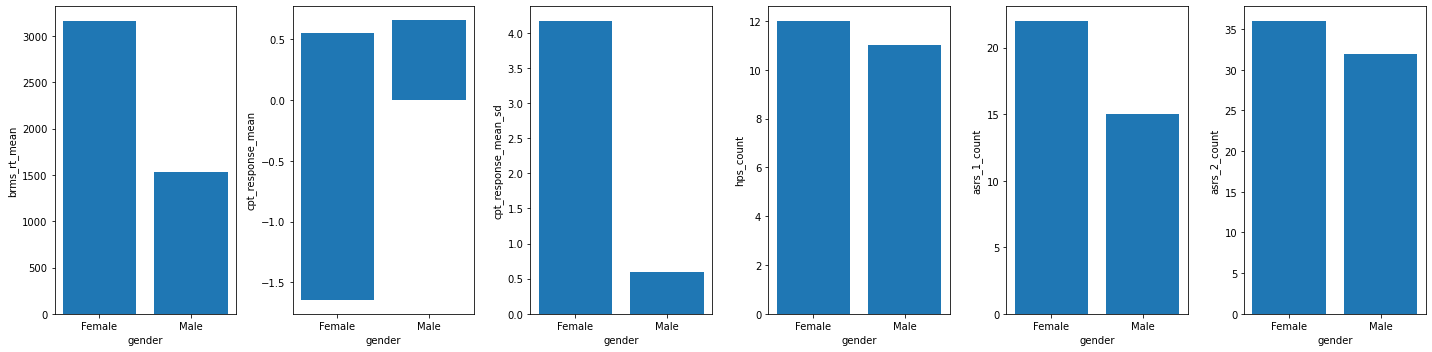

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

axes[0].bar(result_df.gender, result_df.brms_rt_mean)
axes[0].set_xlabel("gender")
axes[0].set_ylabel("brms_rt_mean")

axes[1].bar(result_df.gender, result_df.cpt_response_mean)
axes[1].set_xlabel("gender")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.gender, result_df.cpt_response_sd)
axes[2].set_xlabel("gender")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.gender, result_df.hps_count)
axes[3].set_xlabel("gender")
axes[3].set_ylabel("hps_count")
fig.tight_layout(),

axes[4].bar(result_df.gender, result_df.asrs_1_count)
axes[4].set_xlabel("gender")
axes[4].set_ylabel("asrs_1_count")
fig.tight_layout()

axes[5].bar(result_df.gender, result_df.asrs_2_count)
axes[5].set_xlabel("gender")
axes[5].set_ylabel("asrs_2_count")
fig.tight_layout()

plt.show()